# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

import shap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.multiclass import OneVsRestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

from sklearn.base import clone

from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from scipy.stats import t

from joblib import Parallel
from joblib import delayed
from tqdm_joblib import tqdm_joblib

from itertools import combinations

from collections import defaultdict

from tqdm.notebook import tqdm

In [2]:
warnings.filterwarnings("ignore")

np.seterr(all='ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/04b_modeling_dt'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 2551)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.086147,0.188129,0.527915,0.227357,0.030383,0.066351,0.186189,0.080186,0.030481,0.066564,0.186788,0.080444,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,14.571275,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.065641,0.134688,0.405704,0.187096,0.029668,0.060874,0.183365,0.084561,0.029835,0.061217,0.184397,0.085037,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,17.314756,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.078397,0.169022,0.534108,0.201333,0.032304,0.069647,0.220085,0.082961,0.032325,0.069691,0.220223,0.083013,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,12.422929,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class']

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
sns.set_theme()

## Dictionaty for features mapping to type

In [12]:
feature_to_types = defaultdict(list)

for feature_type, features in features_description.items():
    for feature in features:
        feature_to_types[feature].append(feature_type)

## Dictionary for mapping *class* to *size group*

In [13]:
class_fraction_group_dict = {
    0: '$0< d \leq 2$',
    1: '$2 < d \leq 5$',
    2: '$d > 5$'
}

# Modeling

In [14]:
initial_features_df = features_df.copy()

print(initial_features_df.shape)
initial_features_df.head(3)

(75, 2551)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{1046 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{I_{881}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 25}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.086147,0.188129,0.527915,0.227357,0.030383,0.066351,0.186189,0.080186,0.030481,0.066564,0.186788,0.080444,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,14.571275,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.065641,0.134688,0.405704,0.187096,0.029668,0.060874,0.183365,0.084561,0.029835,0.061217,0.184397,0.085037,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,17.314756,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.078397,0.169022,0.534108,0.201333,0.032304,0.069647,0.220085,0.082961,0.032325,0.069691,0.220223,0.083013,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,12.422929,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Target rate analysis

Mapping hue ~ group:
* Class 0 — $0< d \leq 2$
* Class 1 — $2 < d \leq 5$
* Class 2 — $d > 5$

In [15]:
target_rate_df = pd.DataFrame(samples_description['Fraction_grouped_hue'].value_counts()).sort_values(by='Fraction_grouped_hue')

target_rate_df.T

Fraction_grouped_hue,$0< d \leq 2$,$2 < d \leq 5$,$d > 5$
count,23,29,23


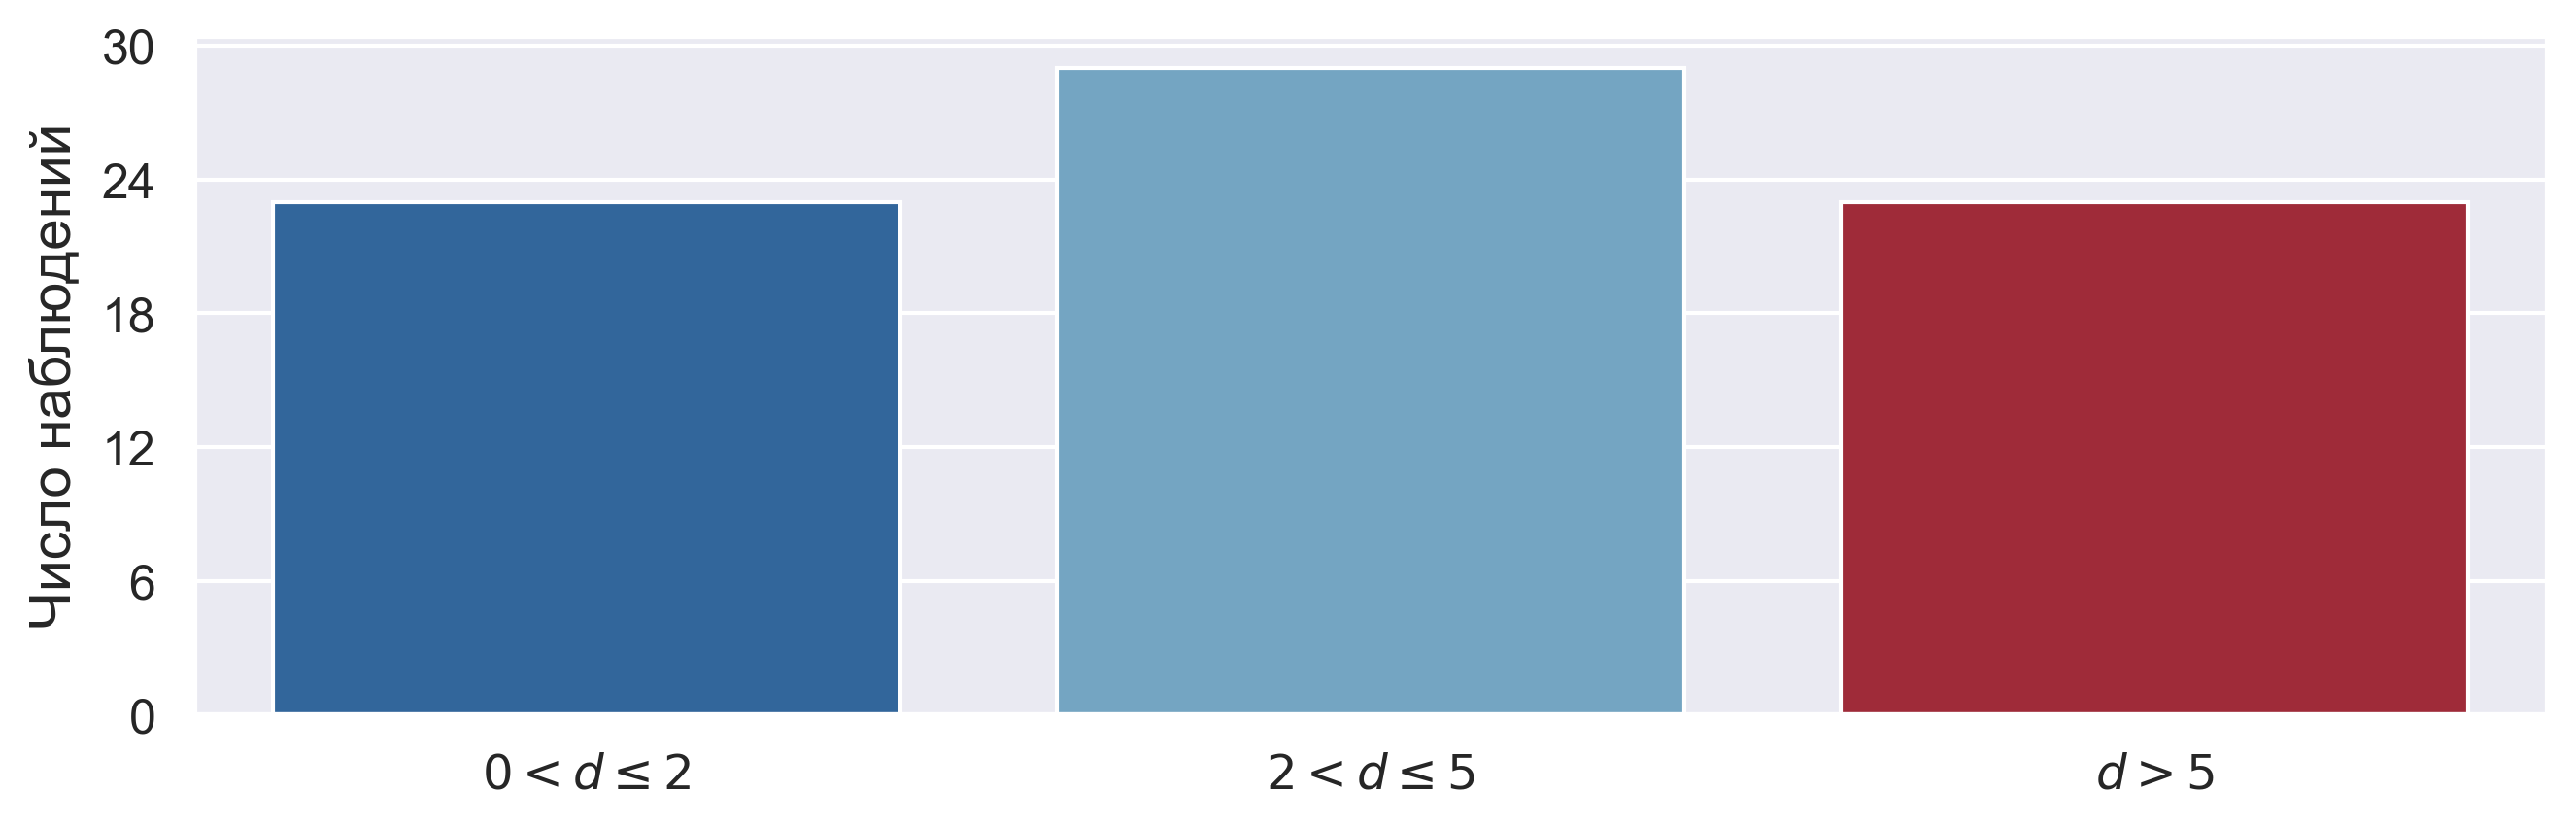

In [16]:
fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

sns.barplot(
    data=target_rate_df,
    x='Fraction_grouped_hue',
    y='count',
    palette=type_color_dict,
    ax=ax
)

ax.set_xlabel('', fontsize=14, labelpad=5)
ax.set_ylabel('Число наблюдений', fontsize=14, labelpad=5)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()

plt.savefig(f'{path_to_save}/target_rate_barplot.png', dpi=600)

plt.show()

## *One-factor* analysis

### Calculation process

In [17]:
def of_analysis(feature, features_df, target, n_splits=5, tree_params=None):
    if tree_params is None:
        tree_params = {}

    X_raw = features_df[[feature]].values
    y = target.values

    mean_val, std_val = X_raw.mean(), X_raw.std()

    estimator = DecisionTreeClassifier(random_state=42, **tree_params)
    estimator.fit(X_raw, y)

    try:
        y_score = estimator.predict_proba(X_raw)
        metric_ovr = roc_auc_score(y, y_score, multi_class='ovr')
    except ValueError:
        metric_ovr = np.nan

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, test_idx in skf.split(X_raw, y):
        X_train, X_test = X_raw[train_idx], X_raw[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        estimator_cv = DecisionTreeClassifier(random_state=42, **tree_params)
        estimator_cv.fit(X_train, y_train)

        try:
            y_score_cv = estimator_cv.predict_proba(X_test)
            score = roc_auc_score(y_test, y_score_cv, multi_class='ovr')
        except ValueError:
            score = np.nan

        cv_scores.append(score)

    return {
        'Feature': feature,
        '$ROC-AUC_{ovr}$': metric_ovr,
        '$ROC-AUC_{ovr}^{CV}$': np.nanmean(cv_scores),
        '$mean$': mean_val,
        '$std$': std_val
    }


In [18]:
tree_params = {
    'max_depth': 2,
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': int(np.log(len(features_df.columns))),
    'criterion': 'entropy'
}

In [19]:
features_list = features_df.columns.tolist()

with tqdm_joblib(desc='Calculation progress', total=len(features_list)):
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(of_analysis)(
            feature,
            features_df,
            target,
            n_splits=5,
            tree_params=tree_params
        )
        for feature in features_list
    )

Calculation progress:   0%|          | 0/2551 [00:00<?, ?it/s]

In [20]:
of_metrics_df = pd.DataFrame(results)

of_metrics_df = of_metrics_df.sort_values(by=['$ROC-AUC_{ovr}^{CV}$', '$ROC-AUC_{ovr}$'], ascending=[False, False])

print(of_metrics_df.shape)
of_metrics_df.head(3)

(2551, 5)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovr}^{CV}$,$mean$,$std$
574,$\frac{I_{3720}}{\overline{I}_{2560 \pm 50}}$,0.880954,0.860449,0.737434,0.659672
573,$\frac{I_{3720}}{\overline{I}_{2560 \pm 25}}$,0.880954,0.858290,0.736527,0.664273
552,$\frac{I_{3720}}{\overline{I}_{3533 \pm 25}}$,0.866331,0.841325,0.429696,0.402944


### Mapping features with their types

In [21]:
rows = []

for _, row in of_metrics_df.iterrows():
    feature = row['Feature']
    feature_types = feature_to_types.get(feature, [])

    for feature_type in feature_types:
        row_copy = row.copy()
        row_copy['Feature_Type'] = feature_type
        rows.append(row_copy)

of_metrics_expanded_df = pd.DataFrame(rows)

print(of_metrics_expanded_df.shape)
of_metrics_expanded_df.head(3)

(5102, 6)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovr}^{CV}$,$mean$,$std$,Feature_Type
574,$\frac{I_{3720}}{\overline{I}_{2560 \pm 50}}$,0.880954,0.860449,0.737434,0.659672,engineered_features_intervals_3800_2200
574,$\frac{I_{3720}}{\overline{I}_{2560 \pm 50}}$,0.880954,0.860449,0.737434,0.659672,engineered_features
573,$\frac{I_{3720}}{\overline{I}_{2560 \pm 25}}$,0.880954,0.858290,0.736527,0.664273,engineered_features_intervals_3800_2200


### Visualization

In [22]:
feature_types = [
    'base_features_peaks_3800_2200',
    'base_features_intervals_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2200',
    'engineered_features_intervals_3800_2200',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [23]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 8,
    'X_NBINS': 8,
    'BAR_WIDTH': 0.7,
    'BAR_ALPHA': 0.85,
    'FIG_DPI': 300,
    'SUBPLOT_WIDTH': 5,
    'SUBPLOT_HEIGHT': 4,
    'TOP_N': 5,
    'COLOR_MAP': {
        'base': 'royalblue',
        'engineered': 'seagreen'
    },
    'LEGEND_FONT_SIZE': 12
}

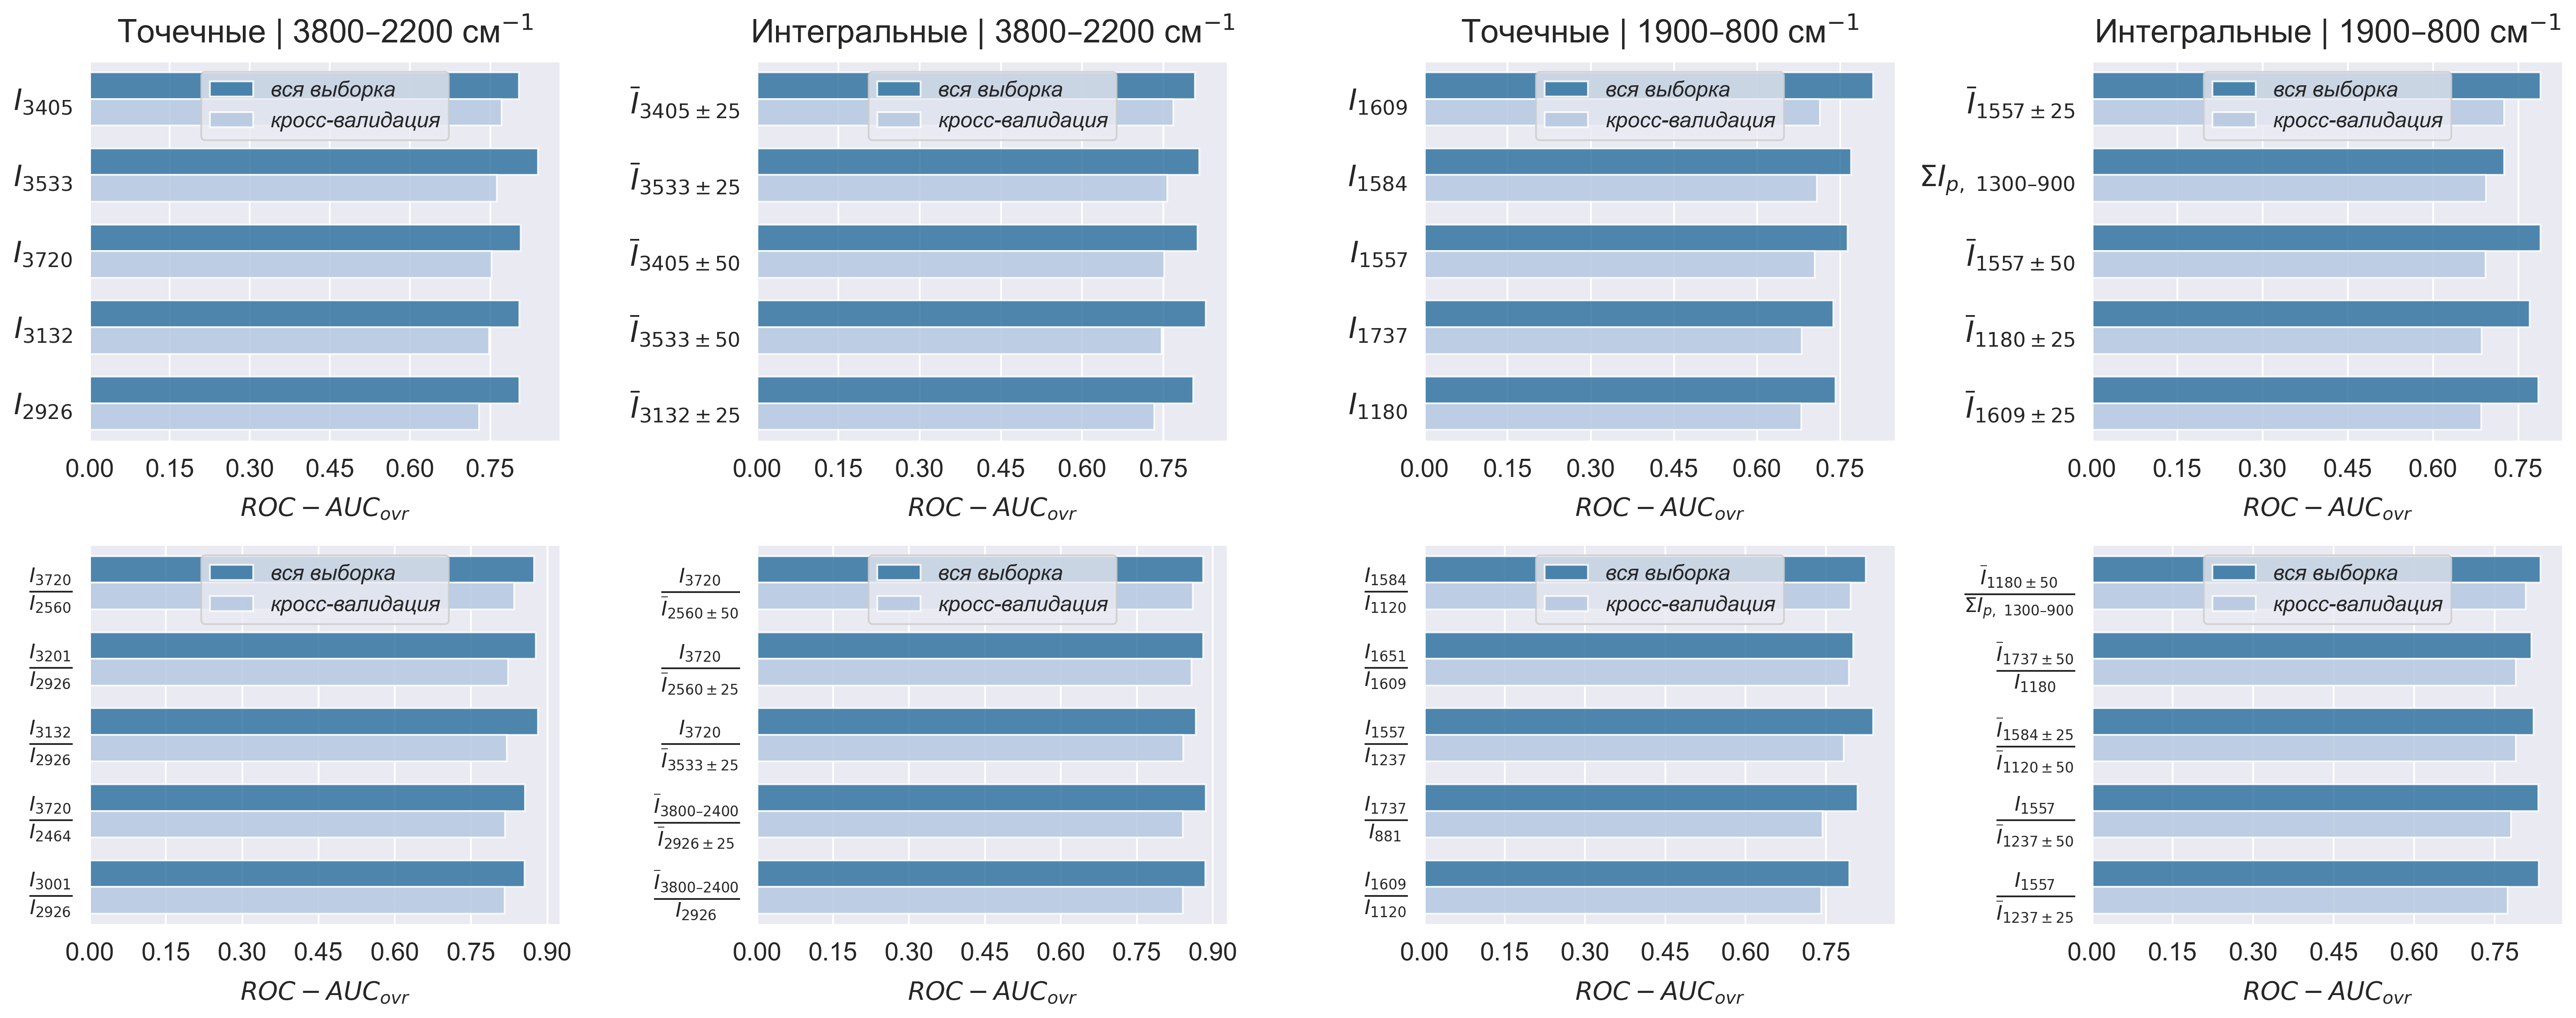

In [24]:
nrows, ncols = 2, 4

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * PLOT_STYLE['SUBPLOT_WIDTH'], nrows * PLOT_STYLE['SUBPLOT_HEIGHT']),
    dpi=PLOT_STYLE['FIG_DPI']
)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    subset = of_metrics_expanded_df[of_metrics_expanded_df['Feature_Type'] == feature_type]
    
    result_df = (
        subset
        .sort_values(
            by=['$ROC-AUC_{ovr}^{CV}$', '$ROC-AUC_{ovr}$'],
            ascending=[False, False]
        )
        .head(PLOT_STYLE['TOP_N'])
        .copy()
    )

    result_df = result_df[['Feature', '$ROC-AUC_{ovr}$', '$ROC-AUC_{ovr}^{CV}$']]
    
    result_df = result_df.melt(id_vars='Feature', var_name='Type', value_name='ROC-AUC')
    result_df['Type'] = result_df['Type'].map({
        '$ROC-AUC_{ovr}$': 'вся выборка',
        '$ROC-AUC_{ovr}^{CV}$': 'кросс-валидация'
    })

    kind = 'engineered' if 'engineered' in feature_type else 'base'
    color = PLOT_STYLE['COLOR_MAP'][kind]

    ax = axes[i]
    
    sns.barplot(
        data=result_df,
        x='ROC-AUC',
        y='Feature',
        hue='Type',
        ax=ax,
        palette=['#1f77b4', '#aec7e8'],
        width=PLOT_STYLE['BAR_WIDTH'],
        alpha=PLOT_STYLE['BAR_ALPHA']
    )

    if i < 4:
        label = 'Точечные' if 'peaks' in feature_type else 'Интегральные'
        a, b = [s for s in feature_type.split('_') if s.isdigit()][-2:]
        title = f'{label} | {a}–{b} см$^{{-1}}$'
        
        ax.set_title(
            title,
            fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
            fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
            pad=10
        )

    ax.set_xlabel('$ROC-AUC_{ovr}$', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    legend = ax.legend(loc='upper center', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'], frameon=True)
    for text in legend.get_texts():
        text.set_fontstyle('italic')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# plt.savefig(f'{path_to_save}/of_roc_auc_barplots.png', dpi=600)

plt.show()

### *Hard-check* factor selection

In [25]:
of_features_to_save = (
    of_metrics_df
    .loc[
        (of_metrics_df['$ROC-AUC_{ovr}$'] >= 0.60)
        & (of_metrics_df['$ROC-AUC_{ovr}^{CV}$'] >= 0.60)
        # & (of_metrics_df['$ROC-AUC_{ovr}^{CV}$'] - of_metrics_df['$ROC-AUC_{ovr}$'] >= -0.05)
    ]['Feature']
).tolist()

print(
    f'Число фичей',
    f'(*) до отбора: {len(of_metrics_df["Feature"].unique())}',
    f'(*) после отбора: {len(of_features_to_save)}',
    f'Доля фичей, прошедших однофакторный отбор: {round(len(of_features_to_save) / len(of_metrics_df["Feature"].unique()) * 100, 2)}%',
    sep='\n'
)

Число фичей
(*) до отбора: 2551
(*) после отбора: 2066
Доля фичей, прошедших однофакторный отбор: 80.99%


## Feature selection

### Functions for processing & config-parameters

In [26]:
PLOT_STYLE = {
    'FIGSIZE': (10, 3.3),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'Importance',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 11
}

#### *Feature* importance

In [27]:
def feature_importance_cv(features_df, target, features_to_use=None, tree_params=None, n_splits=5, plot=True, ax=None, max_display=15):
    if tree_params is None:
        tree_params = {}

    if features_to_use is not None:
        features_df = features_df[features_to_use]

    X = features_df.values
    y = target.values
    feature_names = features_df.columns

    importances_list = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, _ in tqdm(skf.split(X, y), total=n_splits, desc='Calculation progress'):
        model = DecisionTreeClassifier(random_state=42, **tree_params)
        model.fit(X[train_idx], y[train_idx])
        importances_list.append(model.feature_importances_)

    importances_mean = np.mean(importances_list, axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_mean
    }).sort_values(by='Importance', ascending=False)

    if plot:
        external_ax = ax is not None
        fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)
        sns.barplot(data=importance_df.head(max_display), y='Feature', x='Importance', ax=ax, palette='viridis')

        ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
        
        ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
        ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
        
        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        if 'X_NBINS' in PLOT_STYLE:
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

        if not external_ax:
            plt.tight_layout()
            plt.show()

    return importance_df

#### *Permutation* importance

In [28]:
def permutation_importance_cv(features_df, target, features_to_use=None, tree_params=None, n_splits=5, n_repeats=10, plot=True, ax=None, max_display=15, scoring='roc_auc_ovr'):
    if tree_params is None:
        tree_params = {}

    if features_to_use is not None:
        features_df = features_df[features_to_use]

    X = features_df.values
    y = target.values
    feature_names = features_df.columns

    importances_list = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, test_idx in tqdm(skf.split(X, y), total=n_splits, desc='Calculation progress'):
        model = DecisionTreeClassifier(random_state=42, **tree_params)
        model.fit(X[train_idx], y[train_idx])
        result = permutation_importance(model, X[test_idx], y[test_idx], n_repeats=n_repeats, scoring=scoring, random_state=42)
        importances_list.append(result.importances_mean)

    importances_mean = np.mean(importances_list, axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_mean
    }).sort_values(by='Importance', ascending=False)

    if plot:
        external_ax = ax is not None
        fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)
        sns.barplot(data=importance_df.head(max_display), y='Feature', x='Importance', ax=ax, palette='magma')

        ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
        
        ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
        ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
        
        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        if 'X_NBINS' in PLOT_STYLE:
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

        if not external_ax:
            plt.tight_layout()
            plt.show()

    return importance_df

#### *SHAP* importance

In [29]:
def shap_importance_cv(features_df, target, features_to_use=None, tree_params=None, n_splits=5, plot=True, ax=None, max_display=15):
    if tree_params is None:
        tree_params = {}

    if features_to_use is not None:
        features_df = features_df[features_to_use]

    X = features_df
    y = target
    feature_names = features_df.columns

    shap_importances_list = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, test_idx in tqdm(skf.split(X, y), total=n_splits, desc='SHAP CV progress'):
        model = DecisionTreeClassifier(random_state=42, **tree_params)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])

        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X.iloc[test_idx])

        mean_abs_shap = np.abs(shap_values.values).mean(axis=0).mean(axis=1)

        shap_importances_list.append(mean_abs_shap)

    shap_importance_mean = np.mean(shap_importances_list, axis=0)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': shap_importance_mean
    }).sort_values(by='Importance', ascending=False)

    if plot:
        external_ax = ax is not None
        fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)
        sns.barplot(data=importance_df.head(max_display), y='Feature', x='Importance', ax=ax, palette='magma')

        ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
        ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
        ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        if 'X_NBINS' in PLOT_STYLE:
            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

        if not external_ax:
            plt.tight_layout()
            plt.show()

    return importance_df

### `3800-2200` cm$^{–1}$

In [30]:
range = '3800_2200'

In [31]:
candidate_features_3800_2200 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '3800_2200' in feature_type:
            candidate_features_3800_2200.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2200)}')

Число фичей для многофакторного анализа: 981


In [32]:
tree_params = {
    'max_depth': 4,
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': int(np.log(len(features_df.columns))),
    'criterion': 'entropy'
}

In [33]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4.5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 5,
    'Y_LABELPAD': 5,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_NBINS': 10
}

*Feature Importance barplot*

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

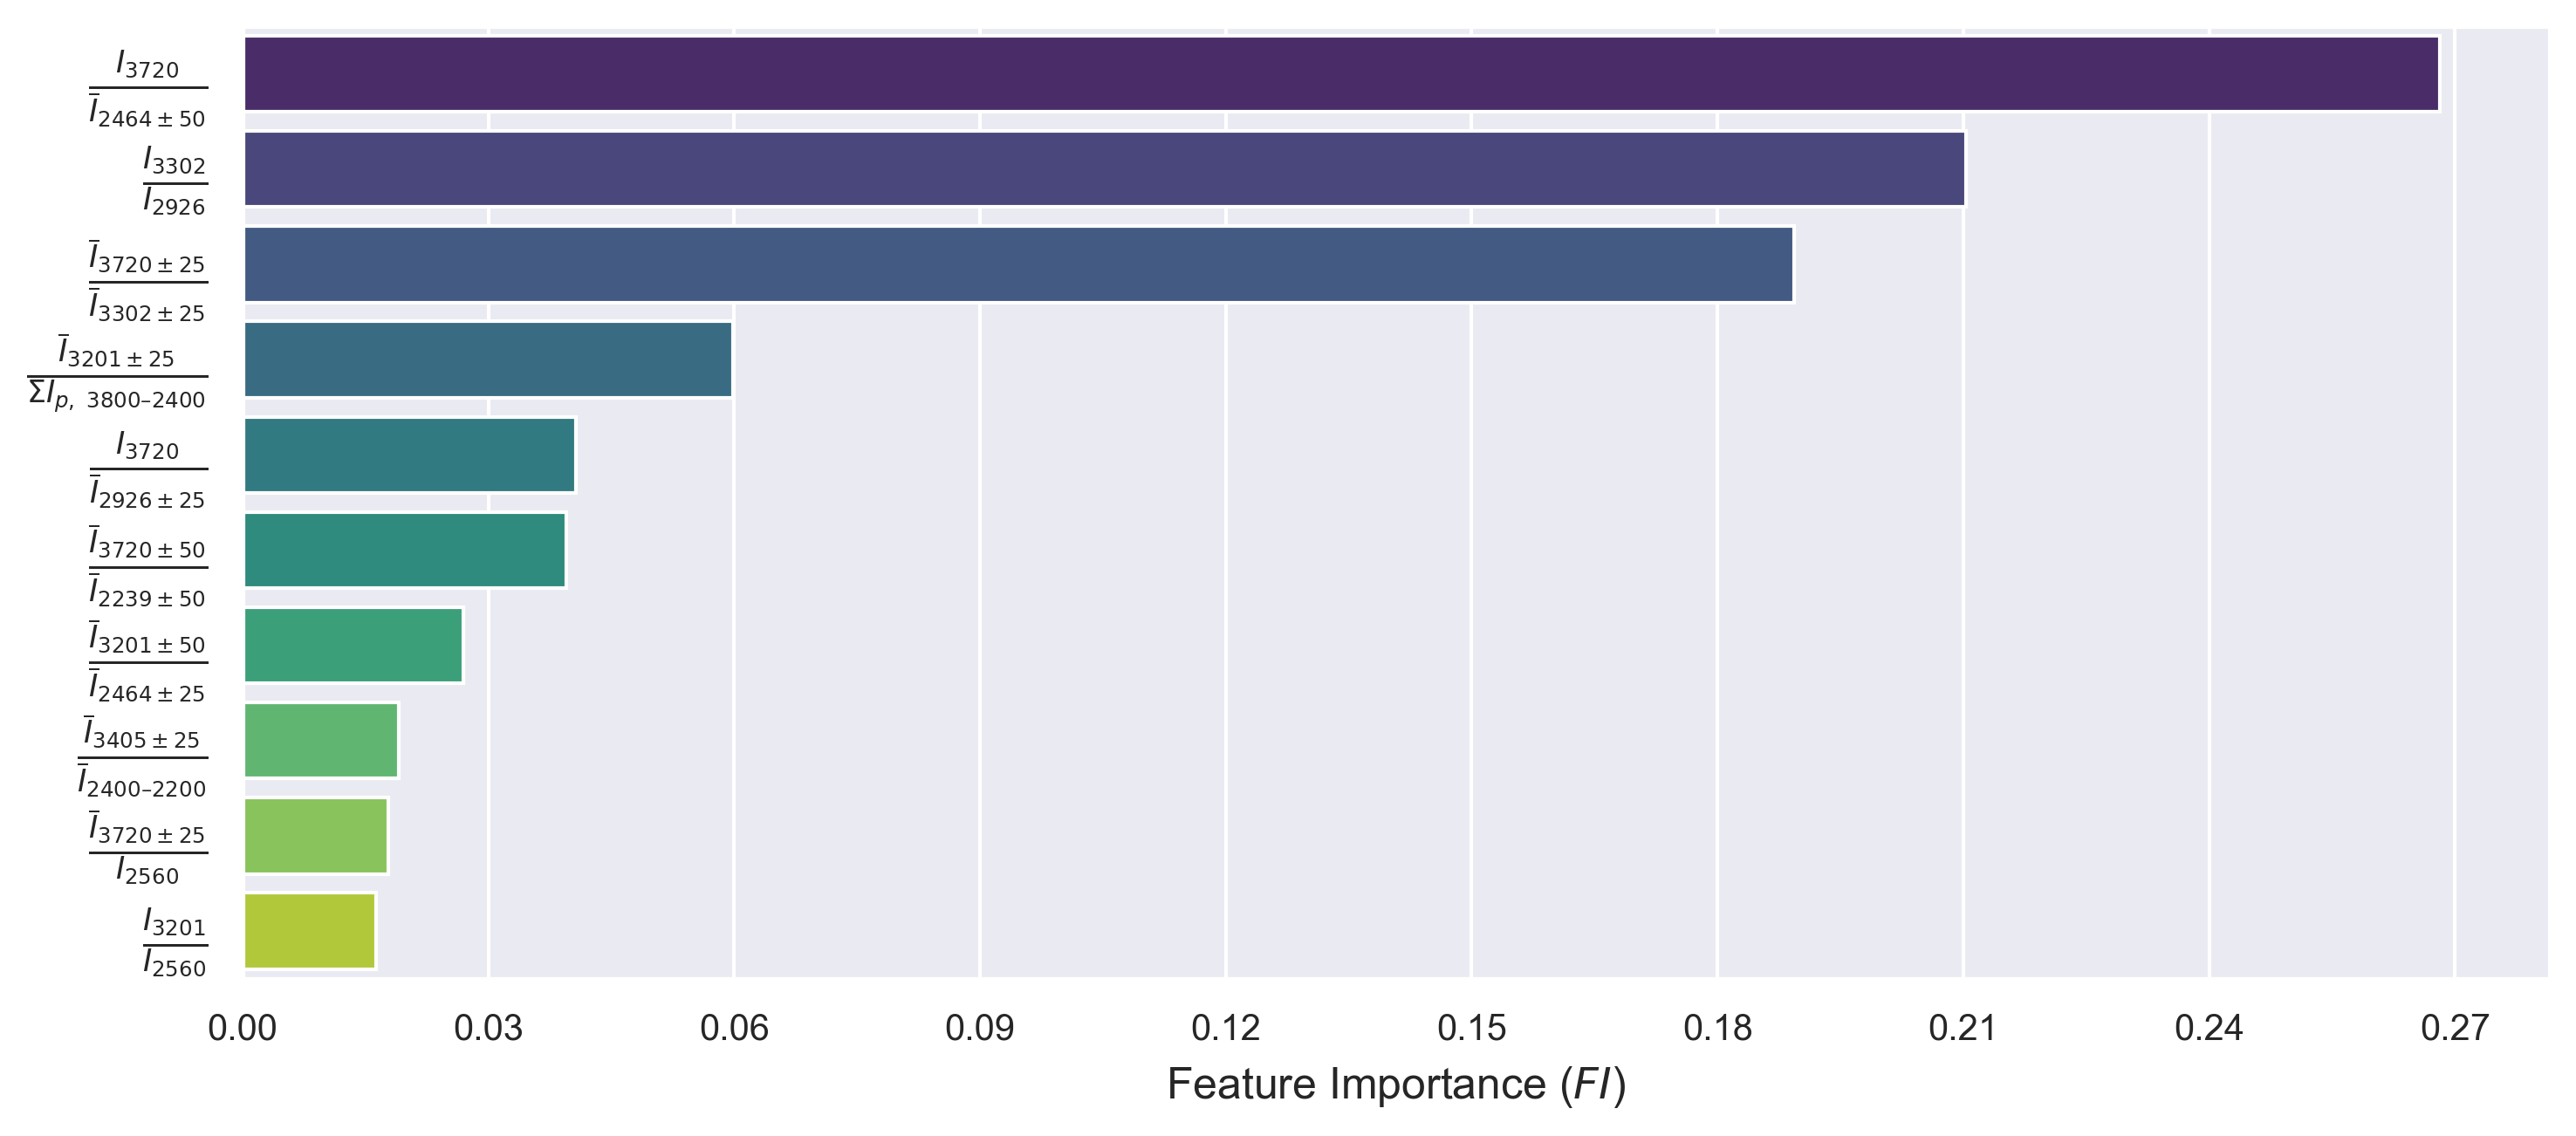

In [34]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

PLOT_STYLE['X_LABEL'] = 'Feature Importance ($FI$)'

feat_importance_df = feature_importance_cv(
    features_df=features_df,
    target=target,
    features_to_use=candidate_features_3800_2200,
    tree_params=tree_params,
    n_splits=5,
    plot=True,
    ax=ax,
    max_display=10
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/feature_importance_{range}', dpi=600)

plt.show()

*Permutation Importance barplot*

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

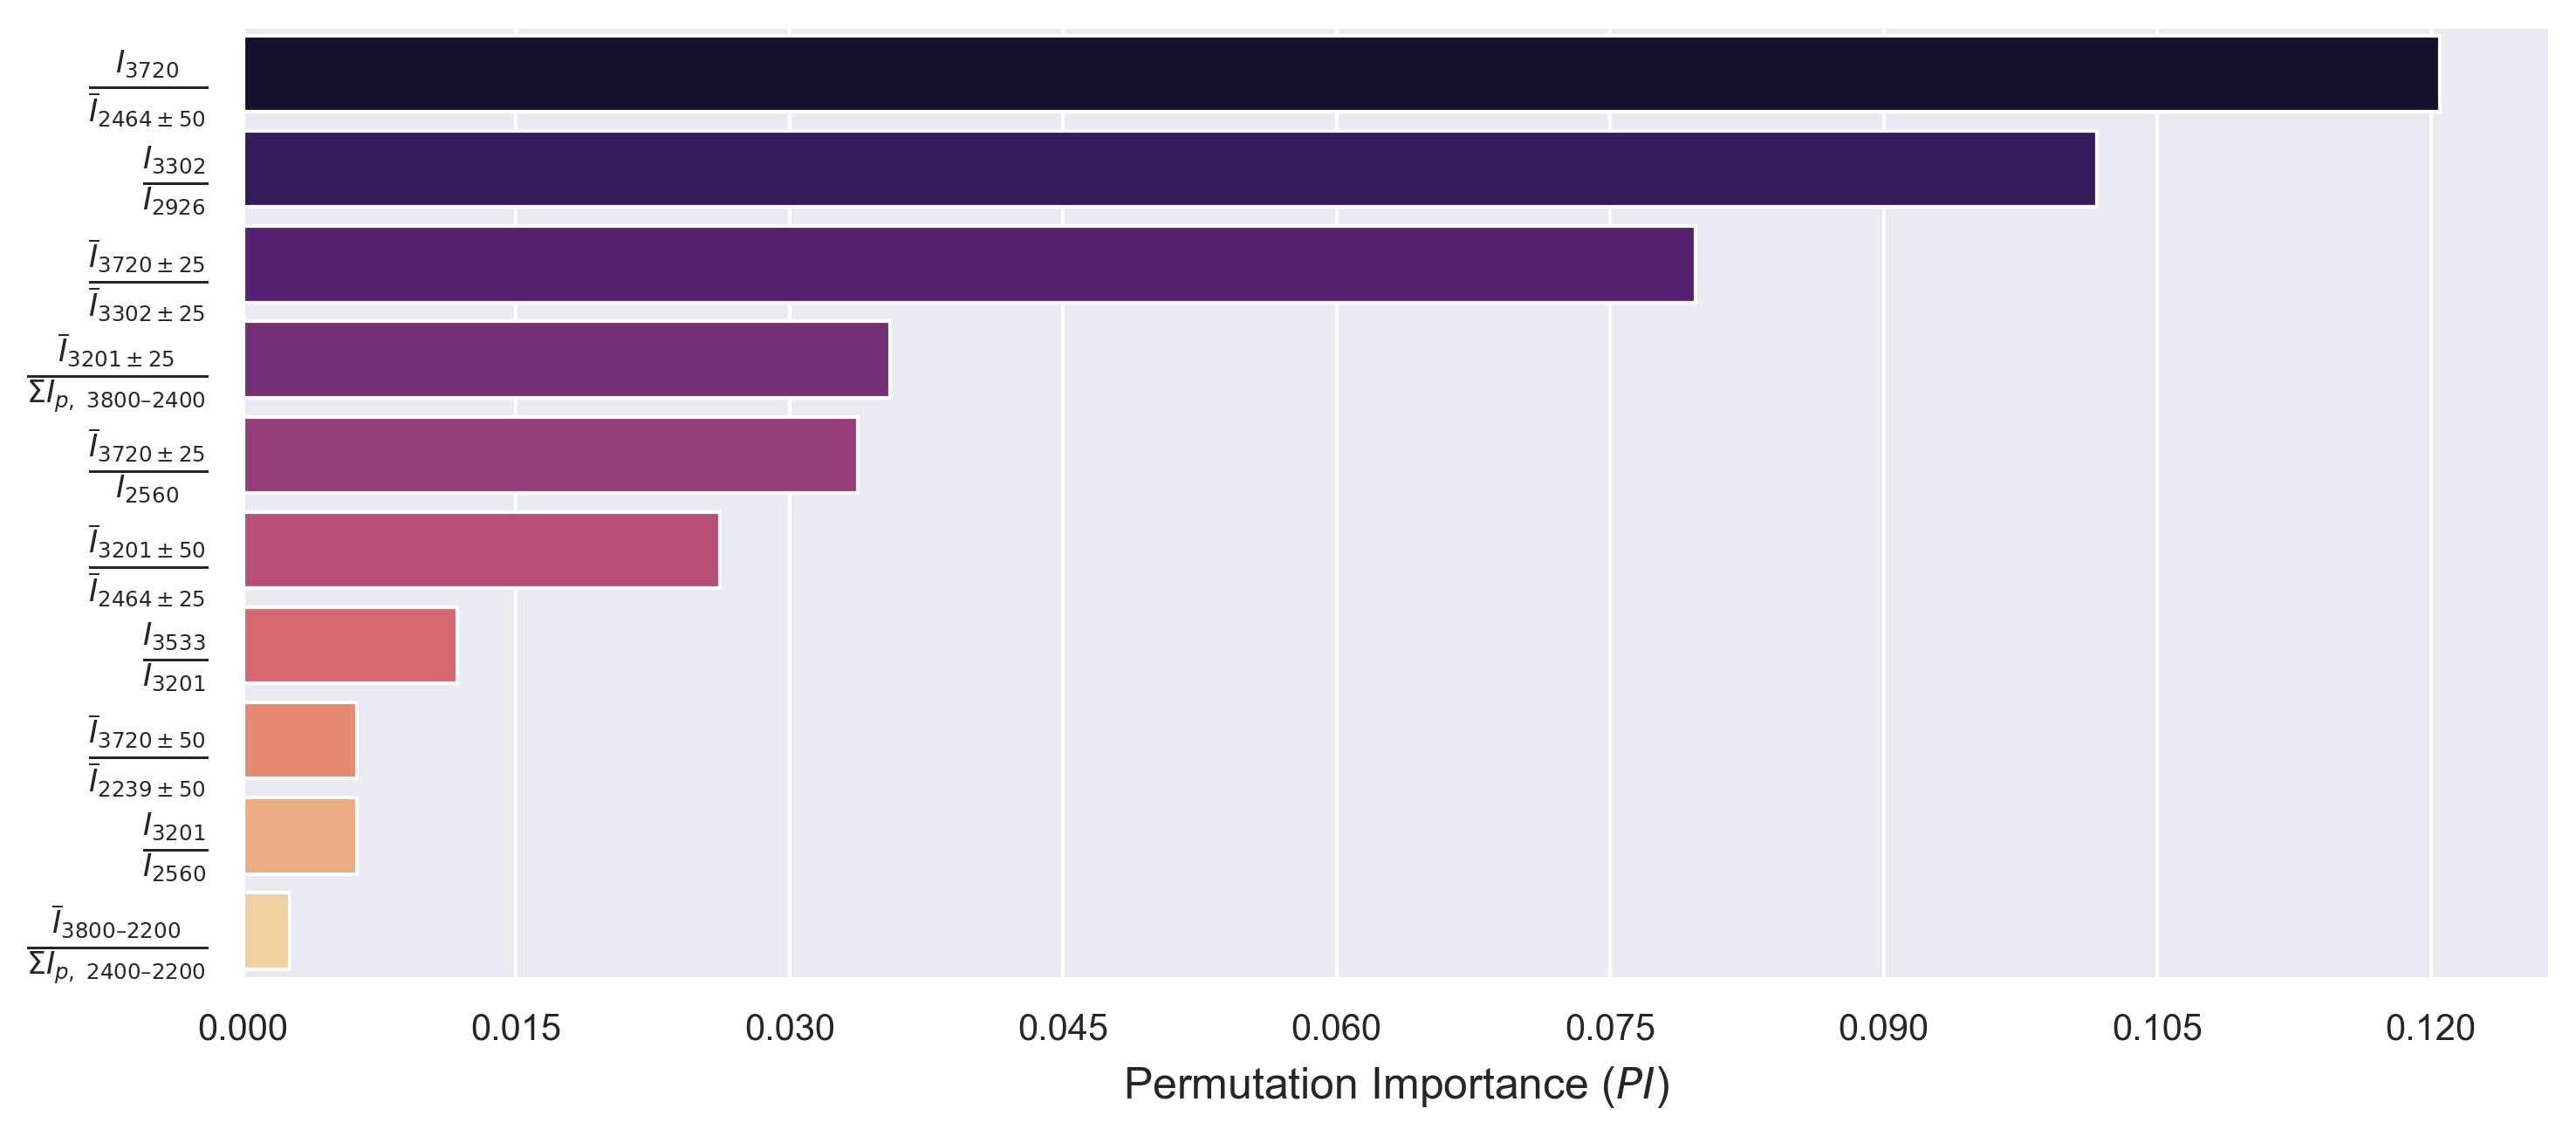

In [35]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

PLOT_STYLE['X_LABEL'] = 'Permutation Importance ($PI$)'

perm_importance_df = permutation_importance_cv(
    features_df=features_df,
    target=target,
    features_to_use=candidate_features_3800_2200,
    tree_params=tree_params,
    n_splits=5,
    n_repeats=20,
    plot=True,
    scoring='roc_auc_ovr',
    ax=ax,
    max_display=10
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/permutation_importance_{range}', dpi=600)

plt.show()

*SHAP-importance barplot*

SHAP CV progress:   0%|          | 0/5 [00:00<?, ?it/s]

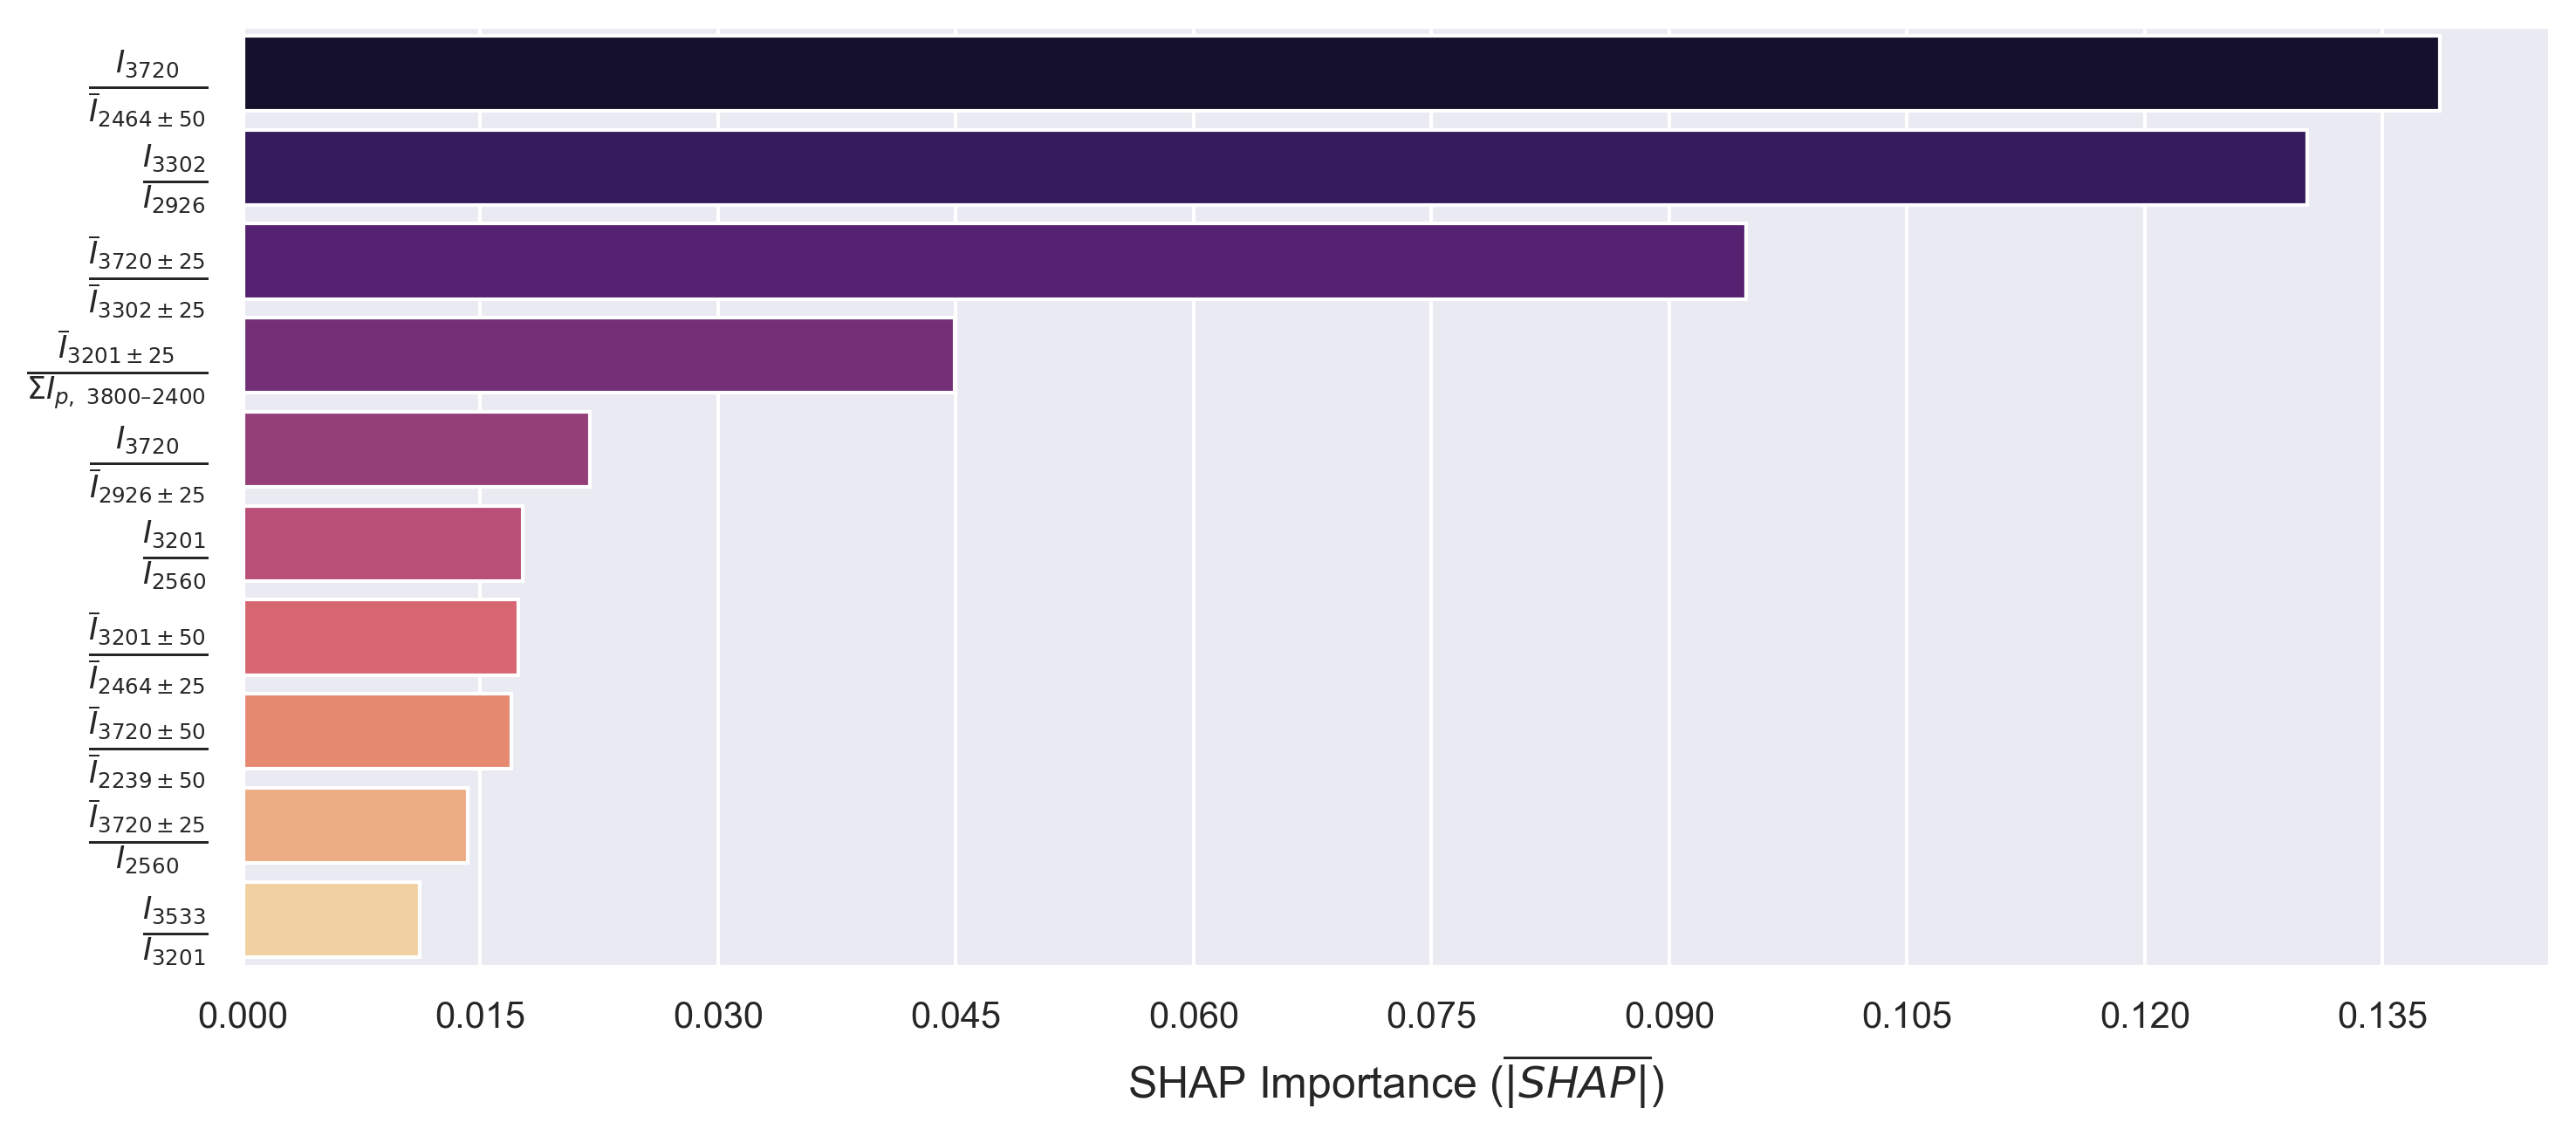

In [36]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

PLOT_STYLE['X_LABEL'] = 'SHAP Importance ($\\overline{|SHAP|}$)'

shap_importance_df = shap_importance_cv(
    features_df=features_df,
    target=target,
    features_to_use=candidate_features_3800_2200,
    tree_params=tree_params,
    n_splits=5,
    plot=True,
    ax=ax,
    max_display=10
)

plt.tight_layout()

# plt.savefig(f'{path_to_save}/shap_importance_{range}', dpi=600)

plt.show()


In [37]:
top_n = 5

selected_feats_3800_2200 = perm_importance_df['Feature'].tolist()[:top_n]

### `1900-800` cm$^{–1}$

In [38]:
range = '1900_800'

In [39]:
candidate_features_1900_800 = []

for feature in of_features_to_save:
    feature_types_lst = feature_to_types[feature]
    for feature_type in feature_types_lst:
        if '1900_800' in feature_type:
            candidate_features_1900_800.append(feature)

print(f'Число фичей для многофакторного анализа: {len(candidate_features_1900_800)}')

Число фичей для многофакторного анализа: 1085


In [40]:
tree_params = {
    'max_depth': 4,
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': int(np.log(len(features_df.columns))),
    'criterion': 'entropy'
}

In [41]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4.5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 5,
    'Y_LABELPAD': 5,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_NBINS': 10
}

*Feature Importance barplot*

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

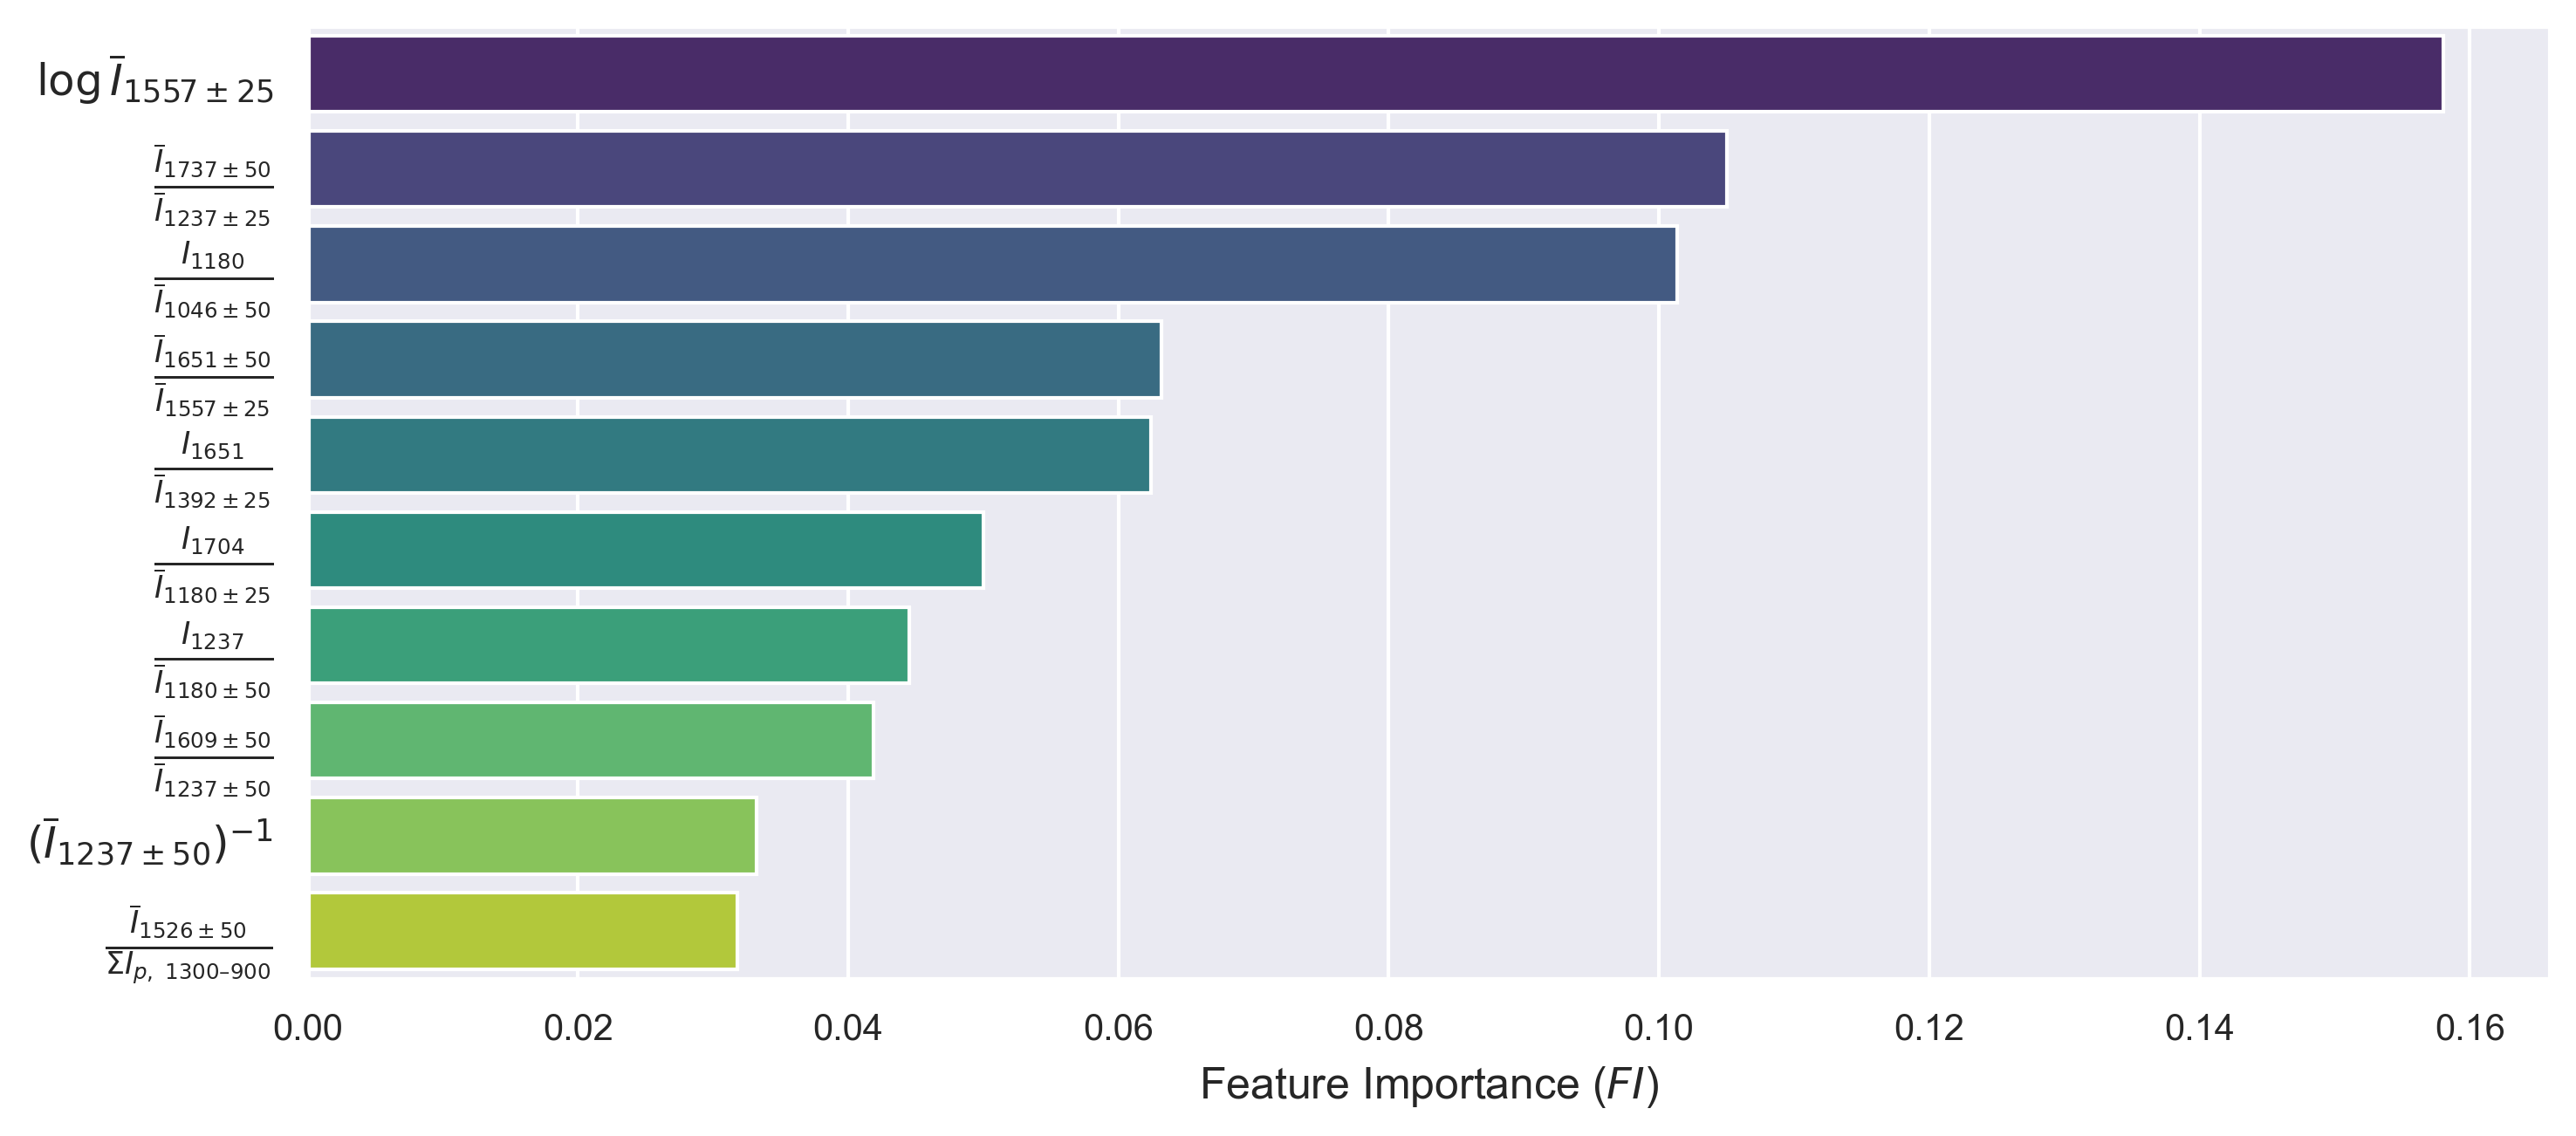

In [42]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

PLOT_STYLE['X_LABEL'] = 'Feature Importance ($FI$)'

feat_importance_df = feature_importance_cv(
    features_df=features_df,
    target=target,
    features_to_use=candidate_features_1900_800,
    tree_params=tree_params,
    n_splits=5,
    plot=True,
    ax=ax,
    max_display=10
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/feature_importance_{range}', dpi=600)

plt.show()

*Permutation Importance barplot*

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

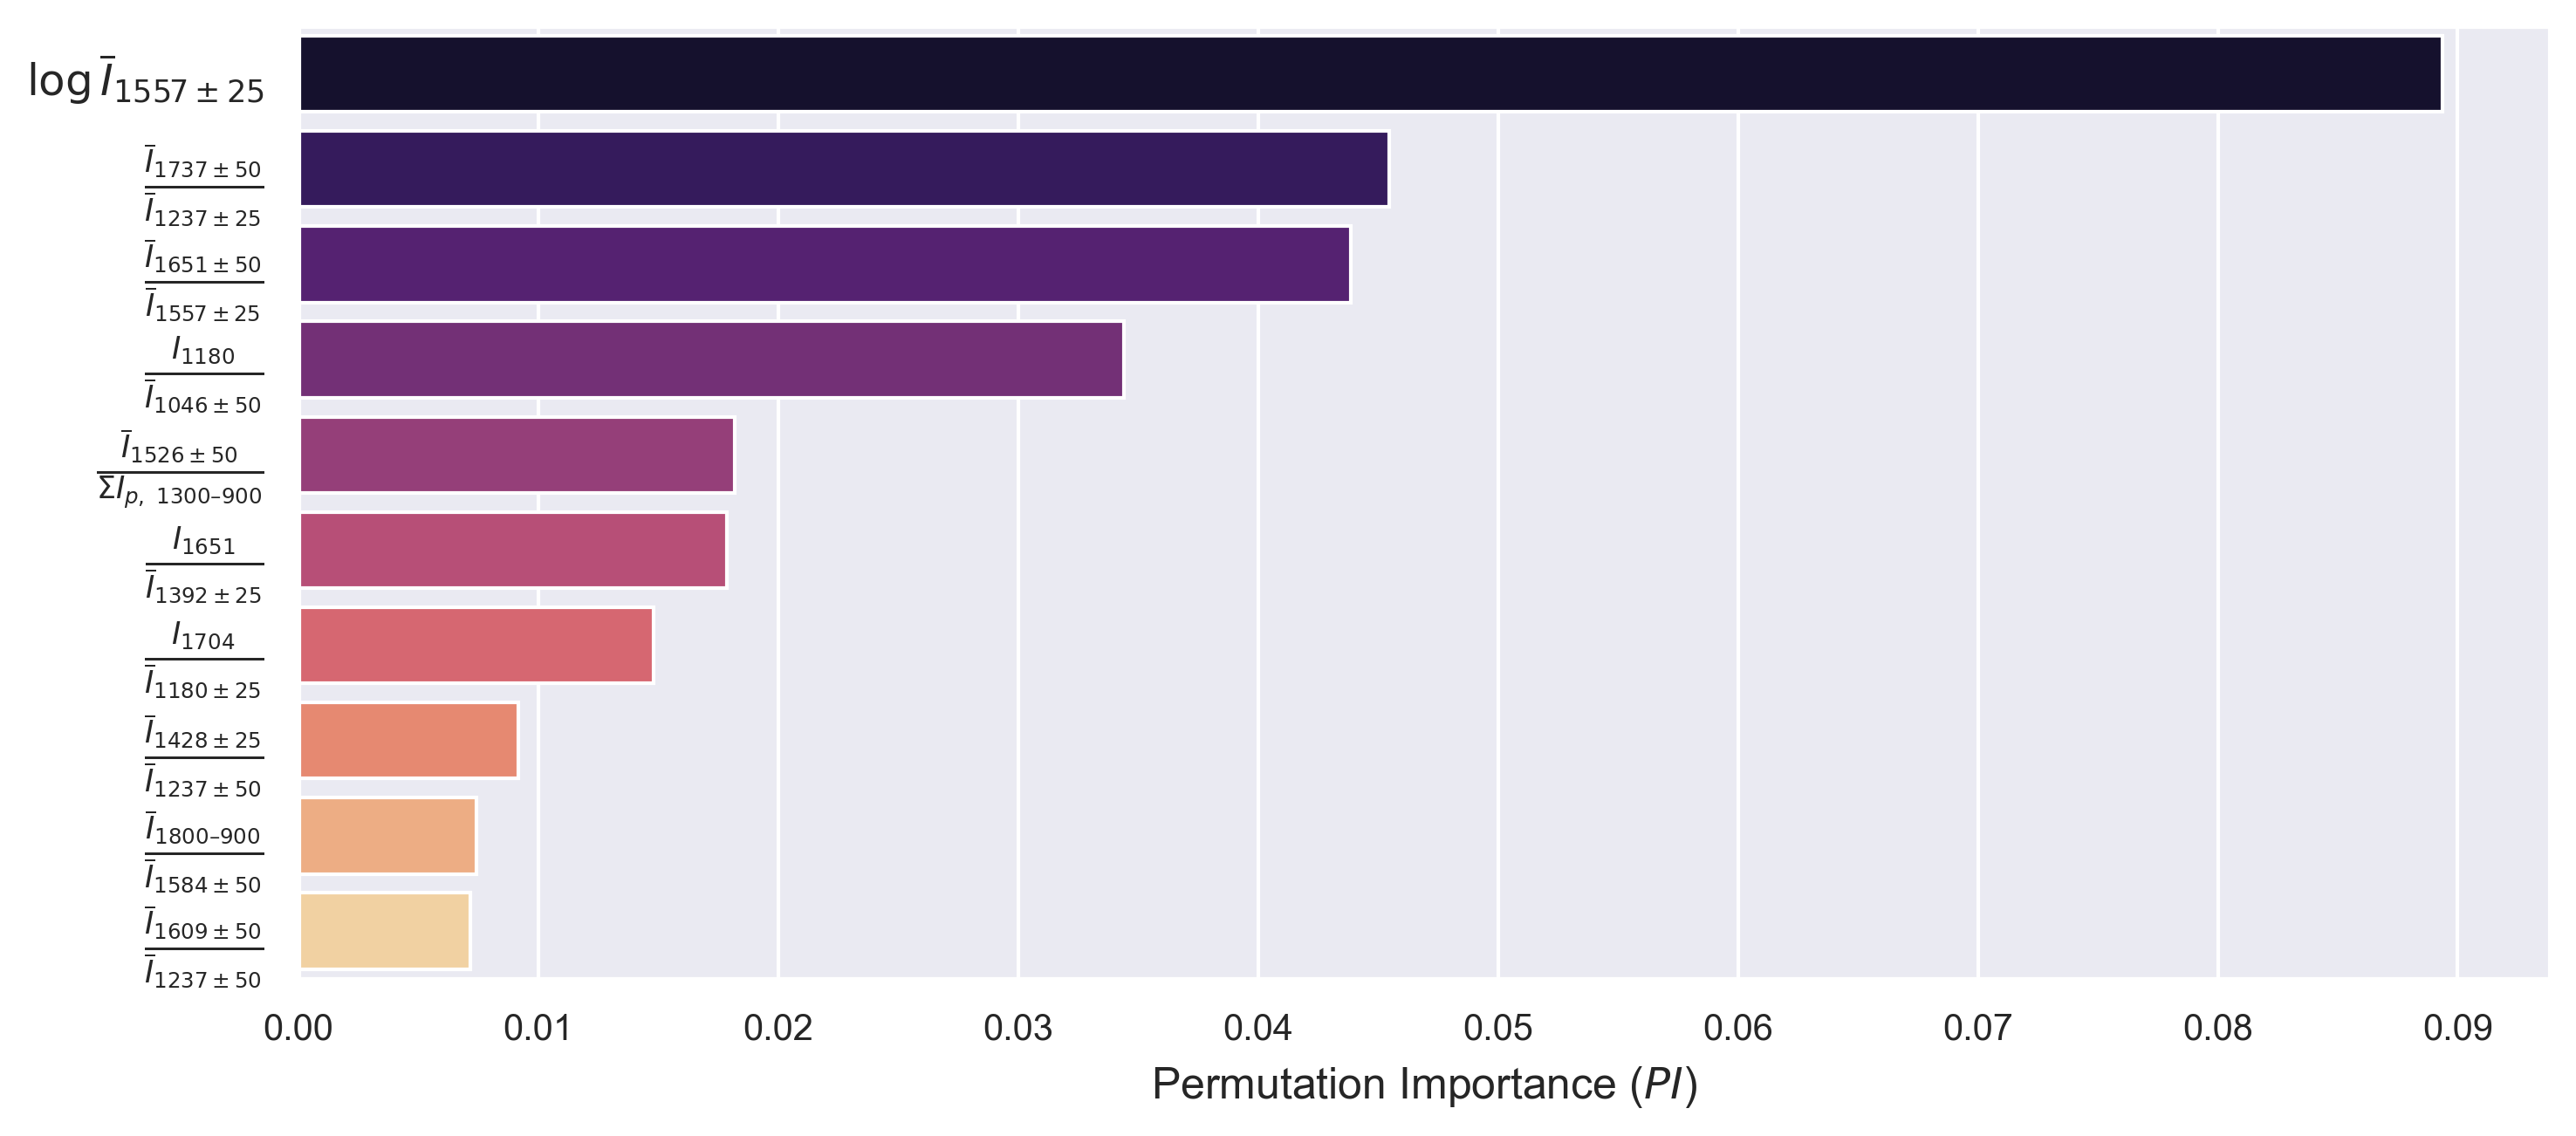

In [43]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

PLOT_STYLE['X_LABEL'] = 'Permutation Importance ($PI$)'

perm_importance_df = permutation_importance_cv(
    features_df=features_df,
    target=target,
    features_to_use=candidate_features_1900_800,
    tree_params=tree_params,
    n_splits=5,
    n_repeats=20,
    plot=True,
    scoring='roc_auc_ovr',
    ax=ax,
    max_display=10
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/permutation_importance_{range}', dpi=600)

plt.show()

In [44]:
top_n = 5

selected_feats_1900_800 = perm_importance_df['Feature'].tolist()[:top_n]

### `3800-2200` x `1900-800` cm$^{–1}$

In [45]:
range = '3800_2200_1900_800'

In [46]:
candidate_features_3800_2200_1900_800 = of_features_to_save.copy()

print(f'Число фичей для многофакторного анализа: {len(candidate_features_3800_2200_1900_800)}')

Число фичей для многофакторного анализа: 2066


In [47]:
tree_params = {
    'max_depth': 4,
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': int(np.log(len(features_df.columns))),
    'criterion': 'entropy'
}

In [48]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4.5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 5,
    'Y_LABELPAD': 5,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_NBINS': 10
}

*Feature Importance barplot*

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

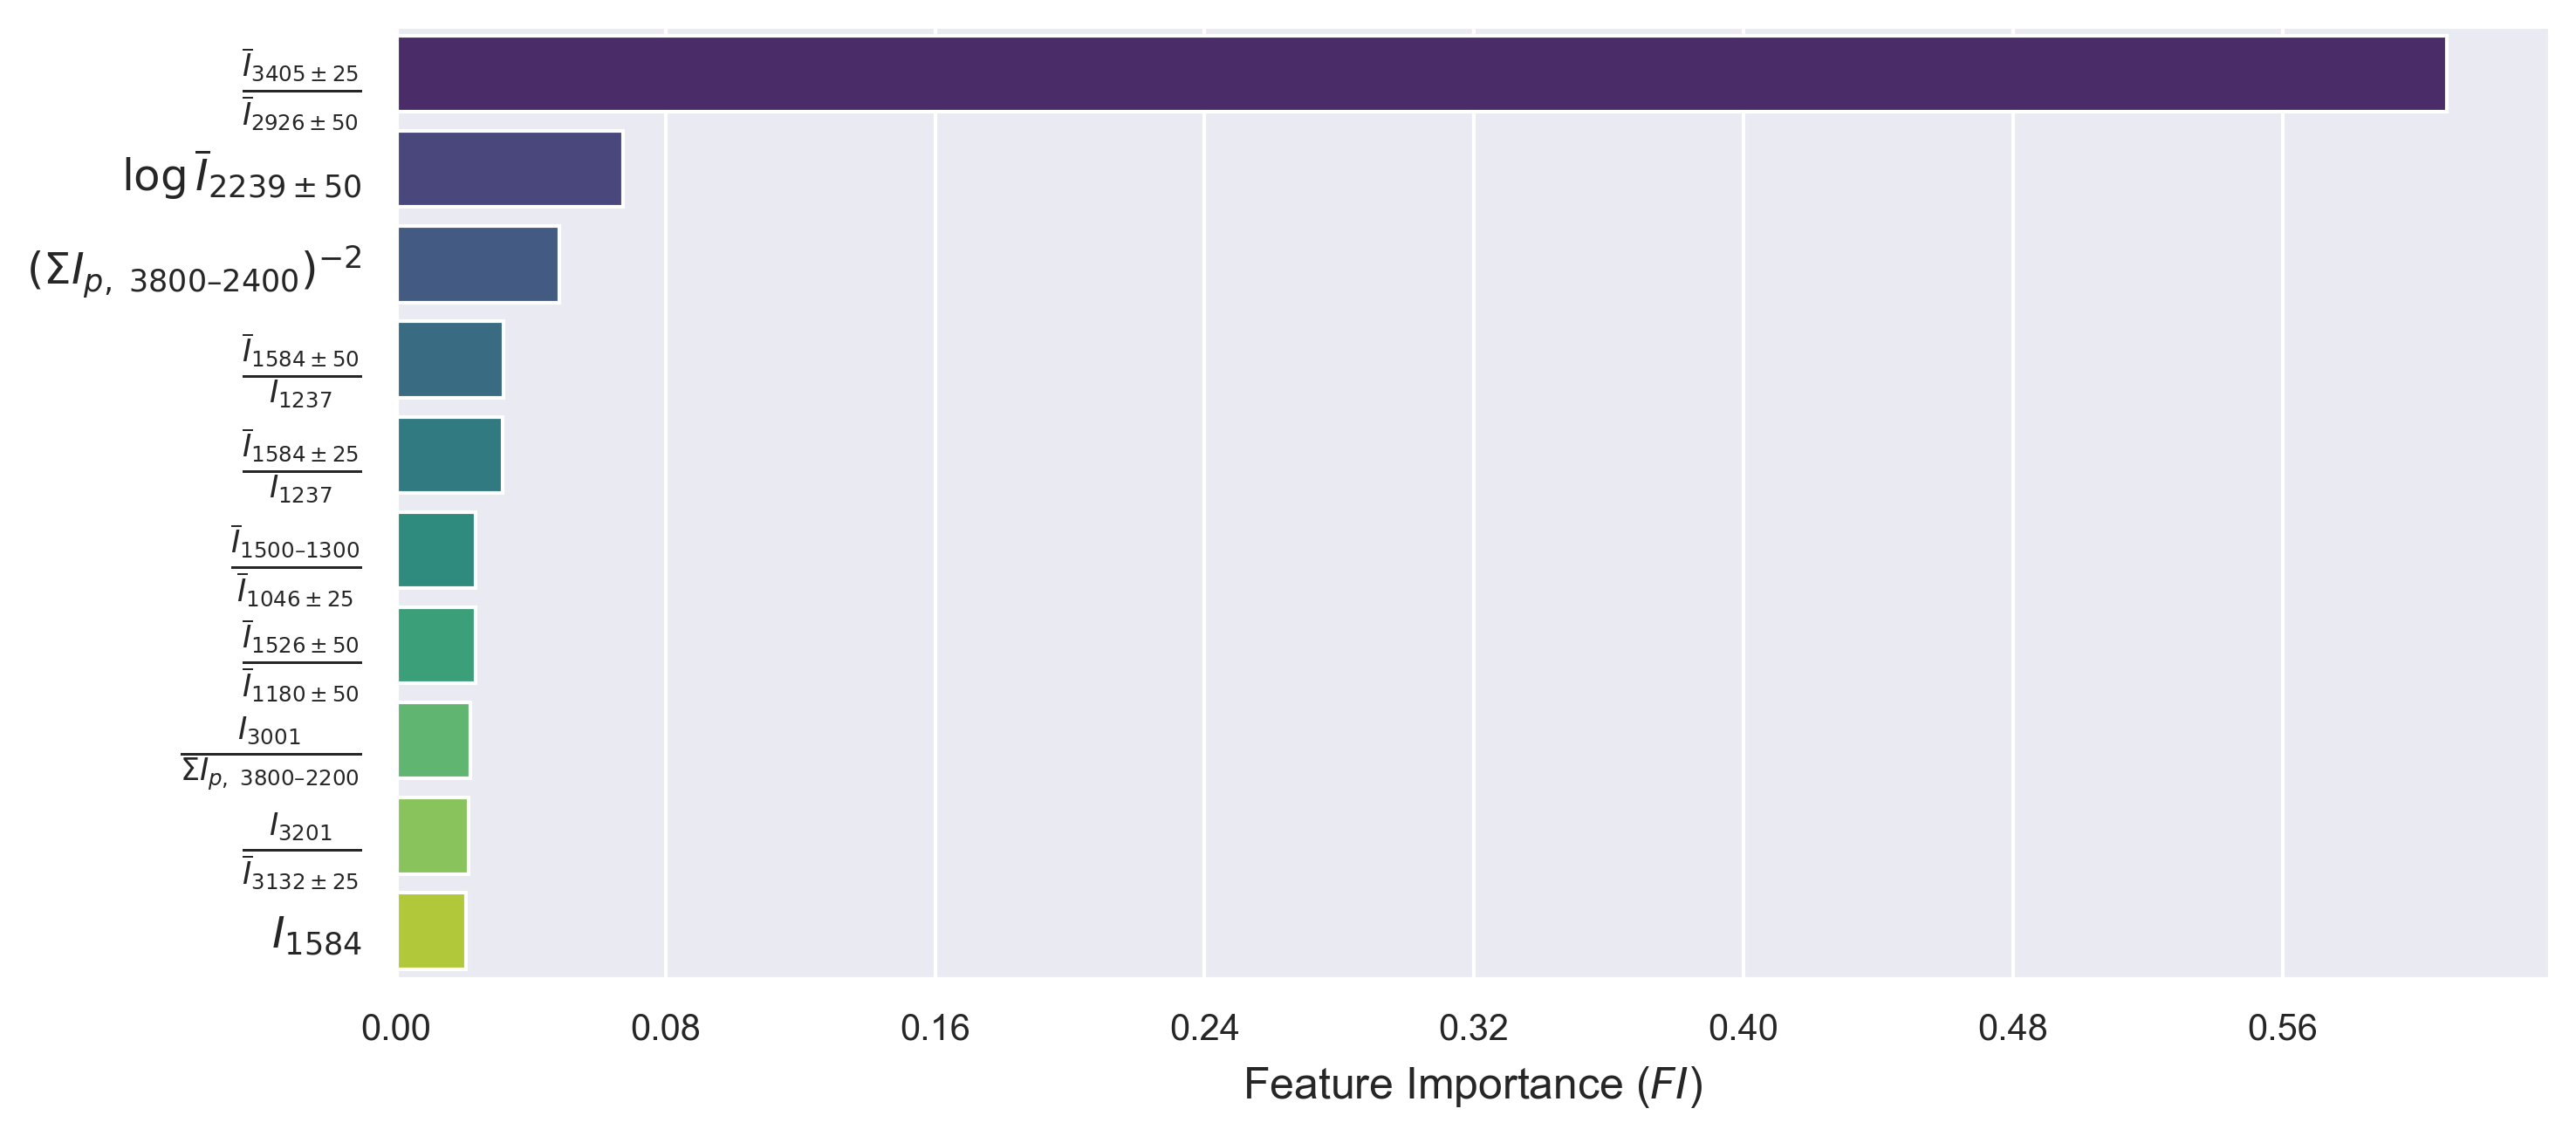

In [49]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

PLOT_STYLE['X_LABEL'] = 'Feature Importance ($FI$)'

feat_importance_df = feature_importance_cv(
    features_df=features_df,
    target=target,
    features_to_use=candidate_features_3800_2200_1900_800,
    tree_params=tree_params,
    n_splits=5,
    plot=True,
    ax=ax,
    max_display=10
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/feature_importance_{range}', dpi=600)

plt.show()

*Permutation Importance barplot*

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

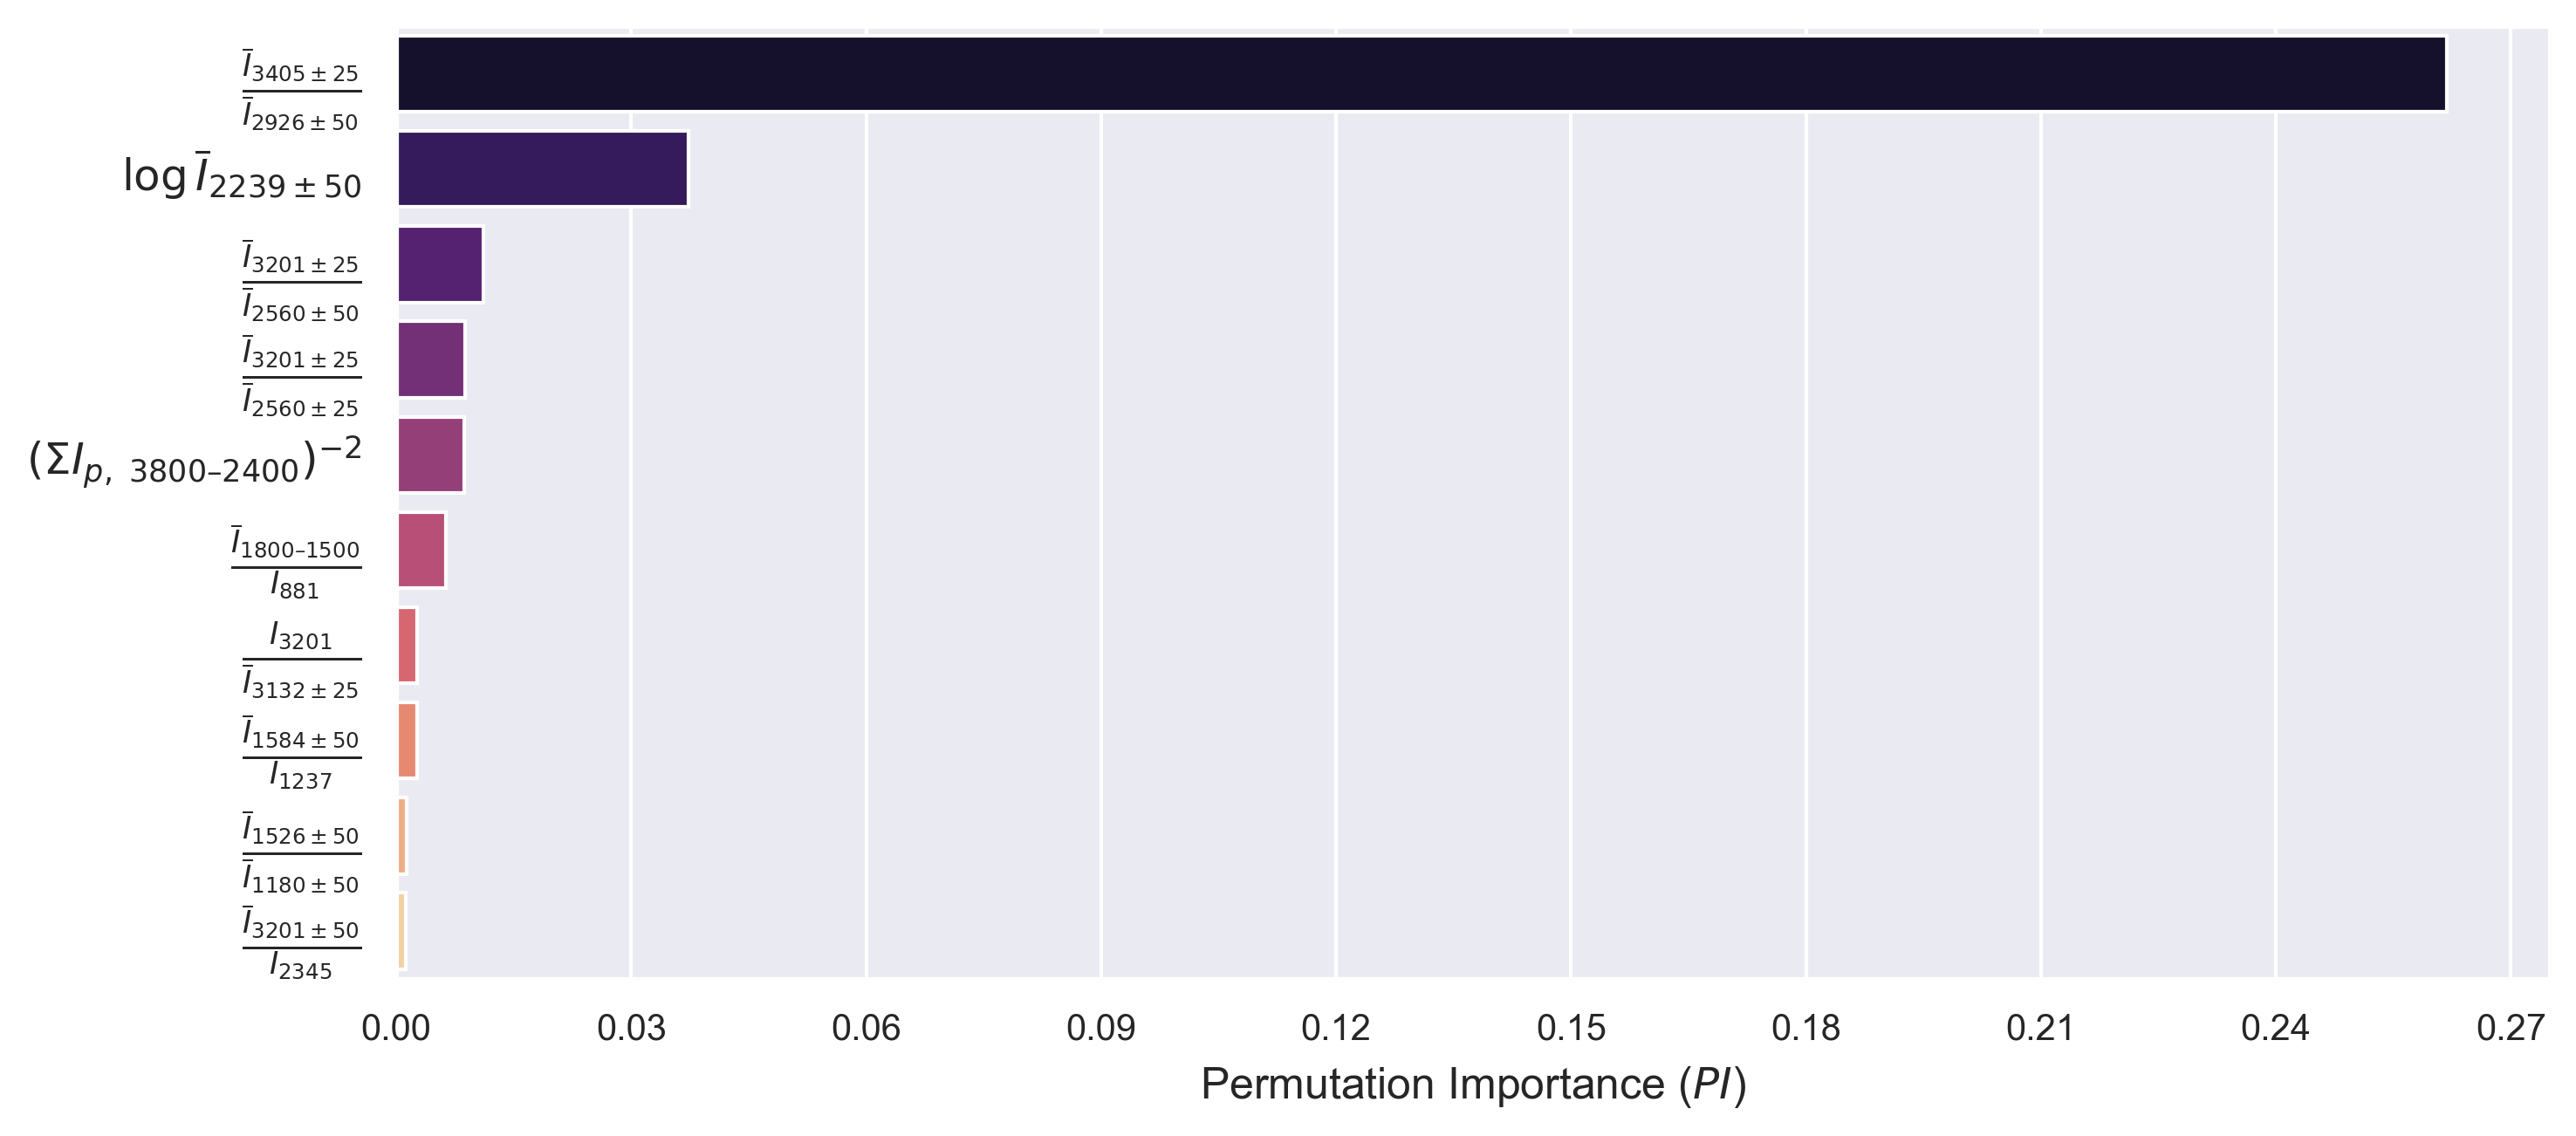

In [50]:
fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE'], dpi=300)

PLOT_STYLE['X_LABEL'] = 'Permutation Importance ($PI$)'

perm_importance_df = permutation_importance_cv(
    features_df=features_df,
    target=target,
    features_to_use=candidate_features_3800_2200_1900_800,
    tree_params=tree_params,
    n_splits=5,
    n_repeats=20,
    plot=True,
    scoring='roc_auc_ovr',
    ax=ax,
    max_display=10
)

plt.tight_layout()

plt.savefig(f'{path_to_save}/permutation_importance_{range}', dpi=600)

plt.show()

In [51]:
top_n = 5

selected_feats_3800_2200_1900_800 = perm_importance_df['Feature'].tolist()[:top_n]

## Models analysis

### Functions for processing

#### Modeling process (*scaling, `lr` fitting, cross-validation, metrics calculation*)

In [52]:
def tree_analysis_gridsearch(df, feature_list, target, param_grid=None, cv_folds=5, random_state=42, scoring_metric='roc_auc_ovr', n_jobs=-1):
    X = df[feature_list].copy()
    y = target.copy()

    def roc_auc_ovr_metric(estimator, X, y_true):
        y_pred_proba = estimator.predict_proba(X)
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')

    def pr_auc_macro_metric(estimator, X, y_true):
        y_pred_proba = estimator.predict_proba(X)
        return average_precision_score(y_true, y_pred_proba, average='macro')

    def ci95(series):
        mean = np.mean(series)
        std = np.std(series, ddof=1)
        n = len(series)
        t_score = t.ppf(0.975, df=n - 1)
        margin = t_score * std / np.sqrt(n)
        return mean, margin

    if param_grid is None:
        param_grid = {
            'max_depth': [3, 4, 5, 6, 7],
            'min_samples_leaf': [1, 2, 5],
            'criterion': ['gini', 'entropy']
        }

    base_tree = DecisionTreeClassifier(random_state=random_state)

    grid_search = GridSearchCV(
        estimator=base_tree,
        param_grid=param_grid,
        scoring=scoring_metric,
        cv=cv_folds,
        refit=True,
        n_jobs=n_jobs,
        verbose=0
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    roc_auc_scores = []
    pr_auc_scores = []

    for train_idx, test_idx in tqdm(skf.split(X, y), total=cv_folds, desc='Calculation progress'):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(best_model)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)

        roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro'))
        pr_auc_scores.append(average_precision_score(y_test, y_pred_proba, average='macro'))

    clf_final = clone(best_model)
    clf_final.fit(X, y)
    y_proba = clf_final.predict_proba(X)

    roc_auc_full = roc_auc_score(y, y_proba, multi_class='ovr', average='macro')
    pr_auc_full = average_precision_score(y, y_proba, average='macro')

    roc_auc_mean, roc_auc_ci = ci95(roc_auc_scores)
    pr_auc_mean, pr_auc_ci = ci95(pr_auc_scores)

    metrics_df = pd.DataFrame({
        '$ROC-AUC_{ovr}$': {
            'Mean': roc_auc_mean,
            '$CI_{95, cv}$': roc_auc_ci,
            '$all$ $sample$': roc_auc_full
        },
        '$PR-AUC_{macro}$': {
            'Mean': pr_auc_mean,
            '$CI_{95, cv}$': pr_auc_ci,
            '$all$ $sample$': pr_auc_full
        }
    })

    return clf_final, X, metrics_df, best_params

#### *ROC*-curves visualization

In [53]:
def plot_roc_curve_per_class(model, X, y_true, class_index, ax):
    y_score = model.predict_proba(X)
    classes = model.classes_
    y_bin = label_binarize(y_true, classes=classes)

    fpr, tpr, _ = roc_curve(y_bin[:, class_index], y_score[:, class_index])
    roc_auc = auc(fpr, tpr)

    class_label = class_fraction_group_dict[class_index]
    class_color = type_color_dict[class_label]

    ax.plot(
        fpr,
        tpr,
        color=class_color,
        linewidth=PLOT_STYLE['LINE_WIDTH'],
        label=fr'$ROC\text{{-}}AUC_{{ovr}} = {roc_auc:.2f}$'
    )

    ax.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        color='gray',
        linewidth=PLOT_STYLE['LINE_WIDTH'] - 1.5,
        label='$ROC-AUC = 0.50$\n$(random$ $classifier)$'
    )

    ax.set_title(class_label, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if 'Y_NBINS' in PLOT_STYLE:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['Y_NBINS']))
    
    ax.legend(loc='lower right', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'])

#### *SHAP*-values visualization (*beeswarm*)

In [54]:
def plot_shap_summary_tree(model, X, features_lst, class_index=0, max_display=20, show_colorbar=True, ax=None):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)

    external_ax = ax is not None
    fig, ax = plt.subplots(figsize=PLOT_STYLE['FIGSIZE']) if ax is None else (None, ax)

    shap.plots.beeswarm(
        shap_values[:, :, class_index],
        max_display=max_display,
        show=False,
        color_bar=show_colorbar,
        ax=ax,
        s=PLOT_STYLE['DOT_SIZE'],
        plot_size=None
    )

    ax.set_title(PLOT_STYLE['TITLE'], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'])
    
    ax.set_xlabel(PLOT_STYLE['X_LABEL'], fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    ax.set_ylabel(PLOT_STYLE['Y_LABEL'], fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

    if 'X_NBINS' in PLOT_STYLE:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    if show_colorbar:
        fig = plt.gcf()
        for other_ax in fig.axes:
            if other_ax is not ax and len(other_ax.get_xticks()) == 0 and len(other_ax.get_yticks()) > 0:
                other_ax.set_ylabel(PLOT_STYLE['LEGEND_TITLE'], fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'])
                other_ax.tick_params(labelsize=PLOT_STYLE['LEGEND_FONT_SIZE'])
                if 'COLORBAR_TICKS' in PLOT_STYLE:
                    other_ax.set_yticklabels(PLOT_STYLE['COLORBAR_TICKS'])

    if not external_ax:
        plt.tight_layout()
        plt.show()

### `3800-2200` cm$^{-1}$

In [55]:
range = '3800_2200'

#### Model optimization

In [56]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

In [57]:
model, X_selected, metrics_df, best_params = tree_analysis_gridsearch(
    df=features_df,
    feature_list=selected_feats_3800_2200,
    target=target,
    param_grid=param_grid,
    cv_folds=5,
    scoring_metric='roc_auc_ovr',
    n_jobs=-1,
    random_state=42
)

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

*Model metrics*

In [58]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Mean,0.834028,0.739822
"$CI_{95, cv}$",0.124447,0.172511
$all$ $sample$,0.965604,0.924591


*Model hyperparameters*

In [59]:
display(best_params)

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2}

#### *ROC*-curves visualization

In [60]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

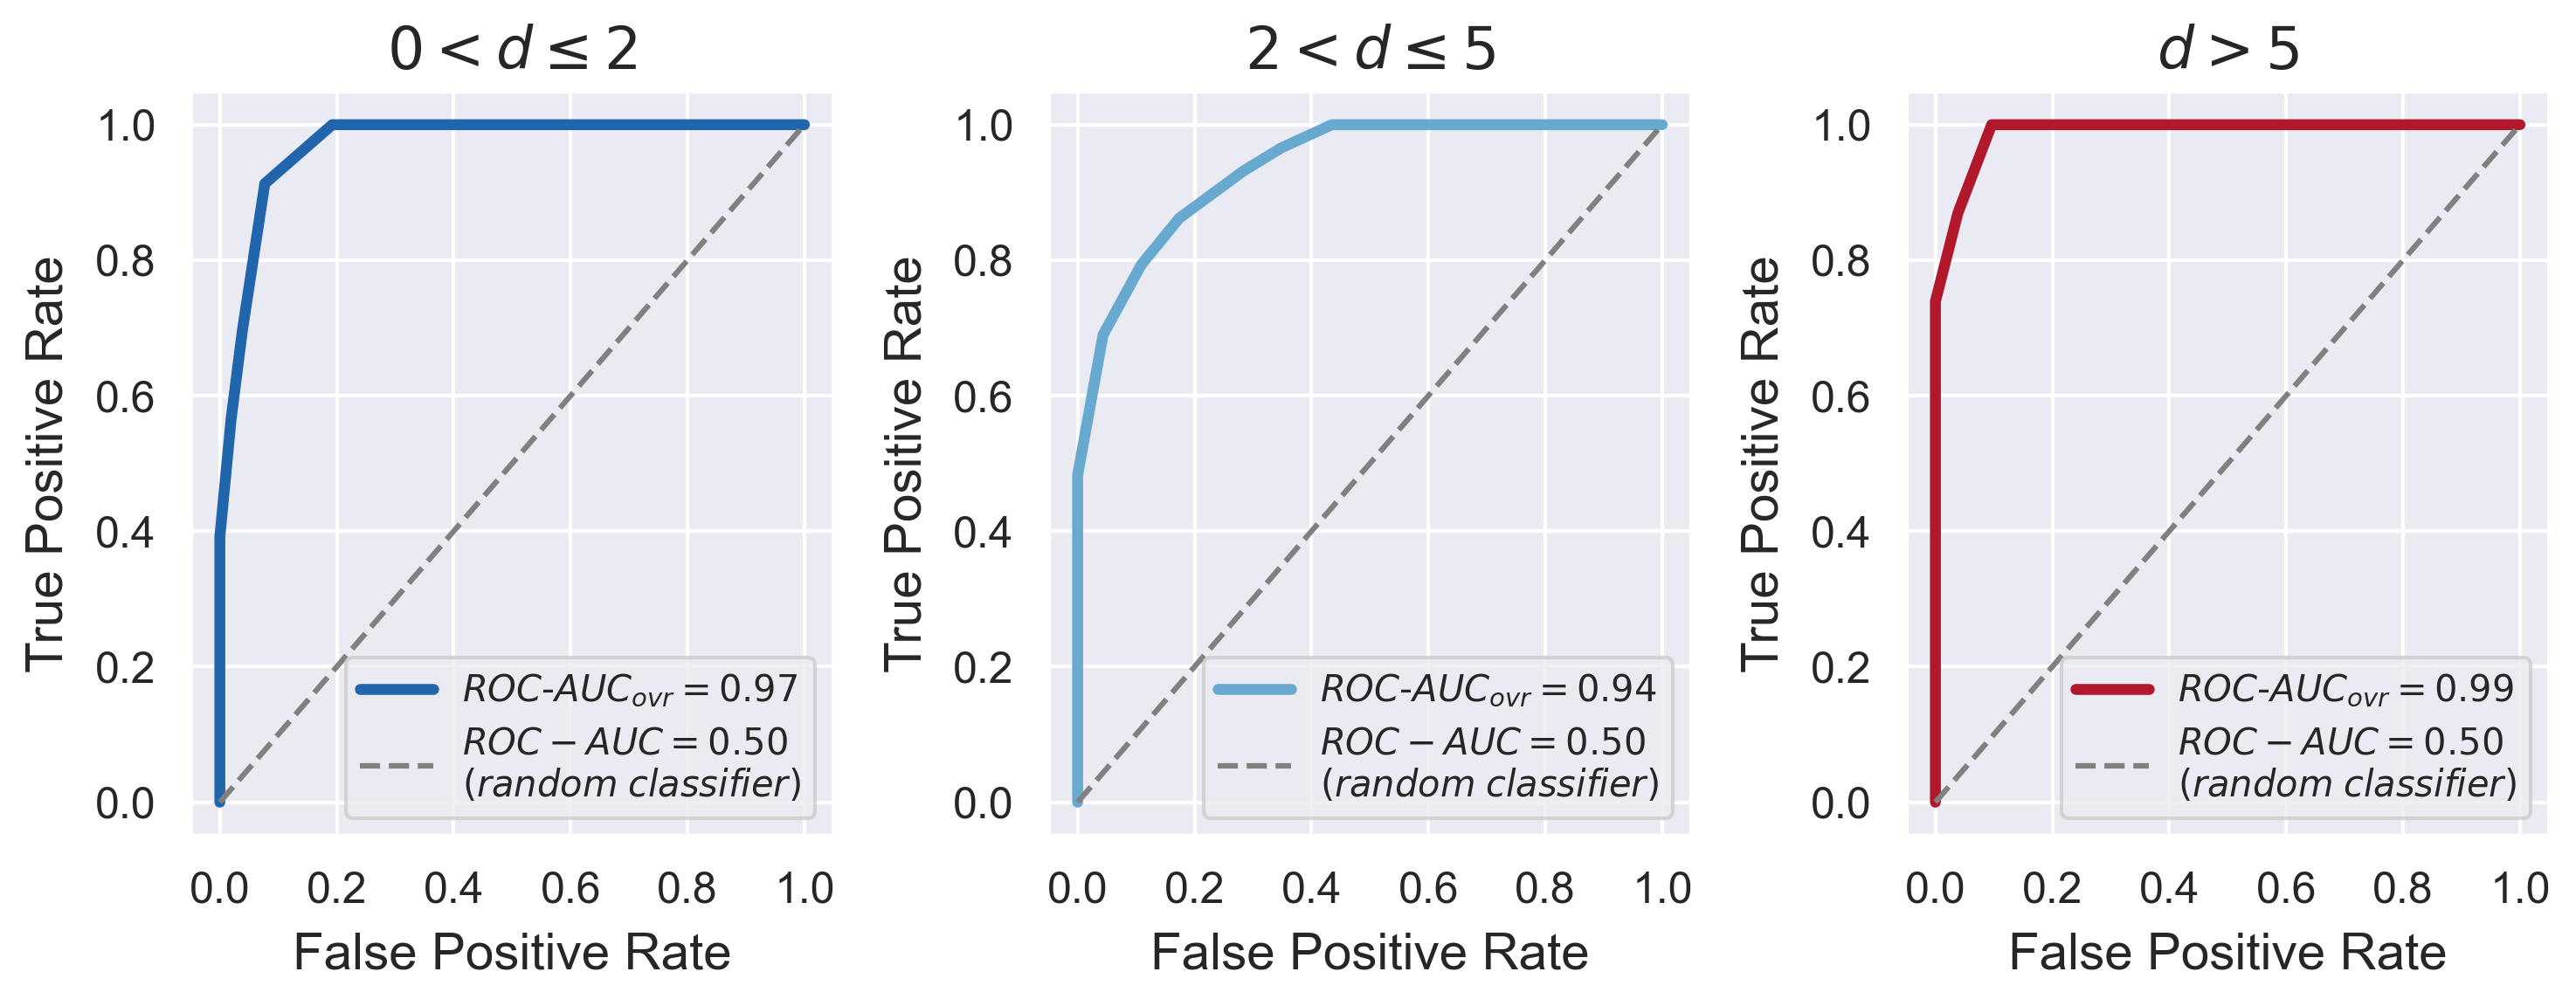

In [62]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X=X_selected,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [63]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

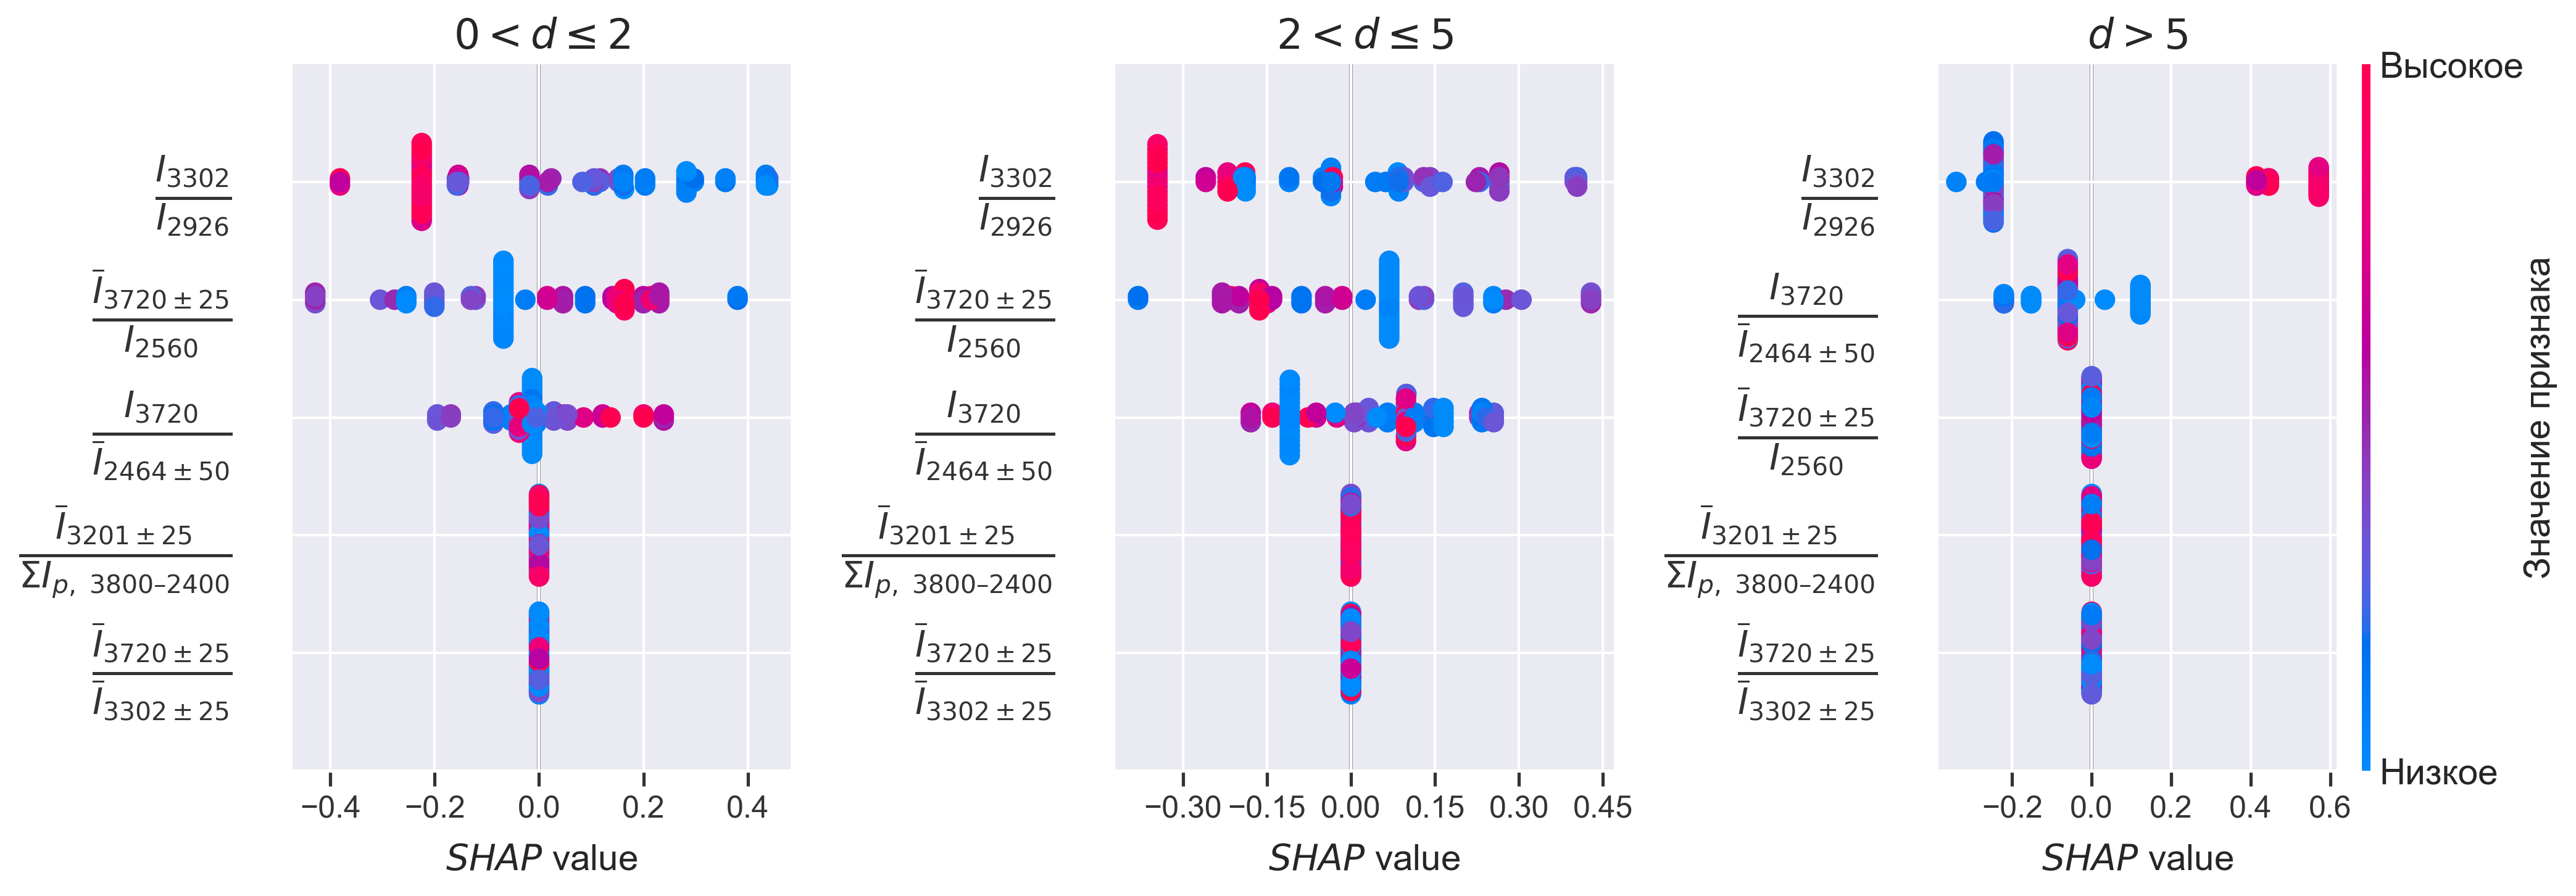

In [64]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    show_colorbar = (i == 2)
    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title

    plot_shap_summary_tree(
        model=model,
        X=X_selected,
        features_lst=selected_feats_3800_2200,
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()
# plt.savefig(f'{path_to_save}/shap_3_subplots_{range}.png', dpi=600)
plt.show()


### `1900-800` cm$^{-1}$

In [65]:
range = '1900_800'

#### Model optimization

In [66]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

In [67]:
model, X_selected, metrics_df, best_params = tree_analysis_gridsearch(
    df=features_df,
    feature_list=selected_feats_1900_800,
    target=target,
    param_grid=param_grid,
    cv_folds=5,
    scoring_metric='roc_auc_ovr',
    n_jobs=-1,
    random_state=42
)

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

*Model metrics*

In [68]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Mean,0.804452,0.666197
"$CI_{95, cv}$",0.063607,0.083311
$all$ $sample$,0.918483,0.826956


*Model hyperparameters*

In [69]:
display(best_params)

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2}

#### *ROC*-curves visualization

In [70]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

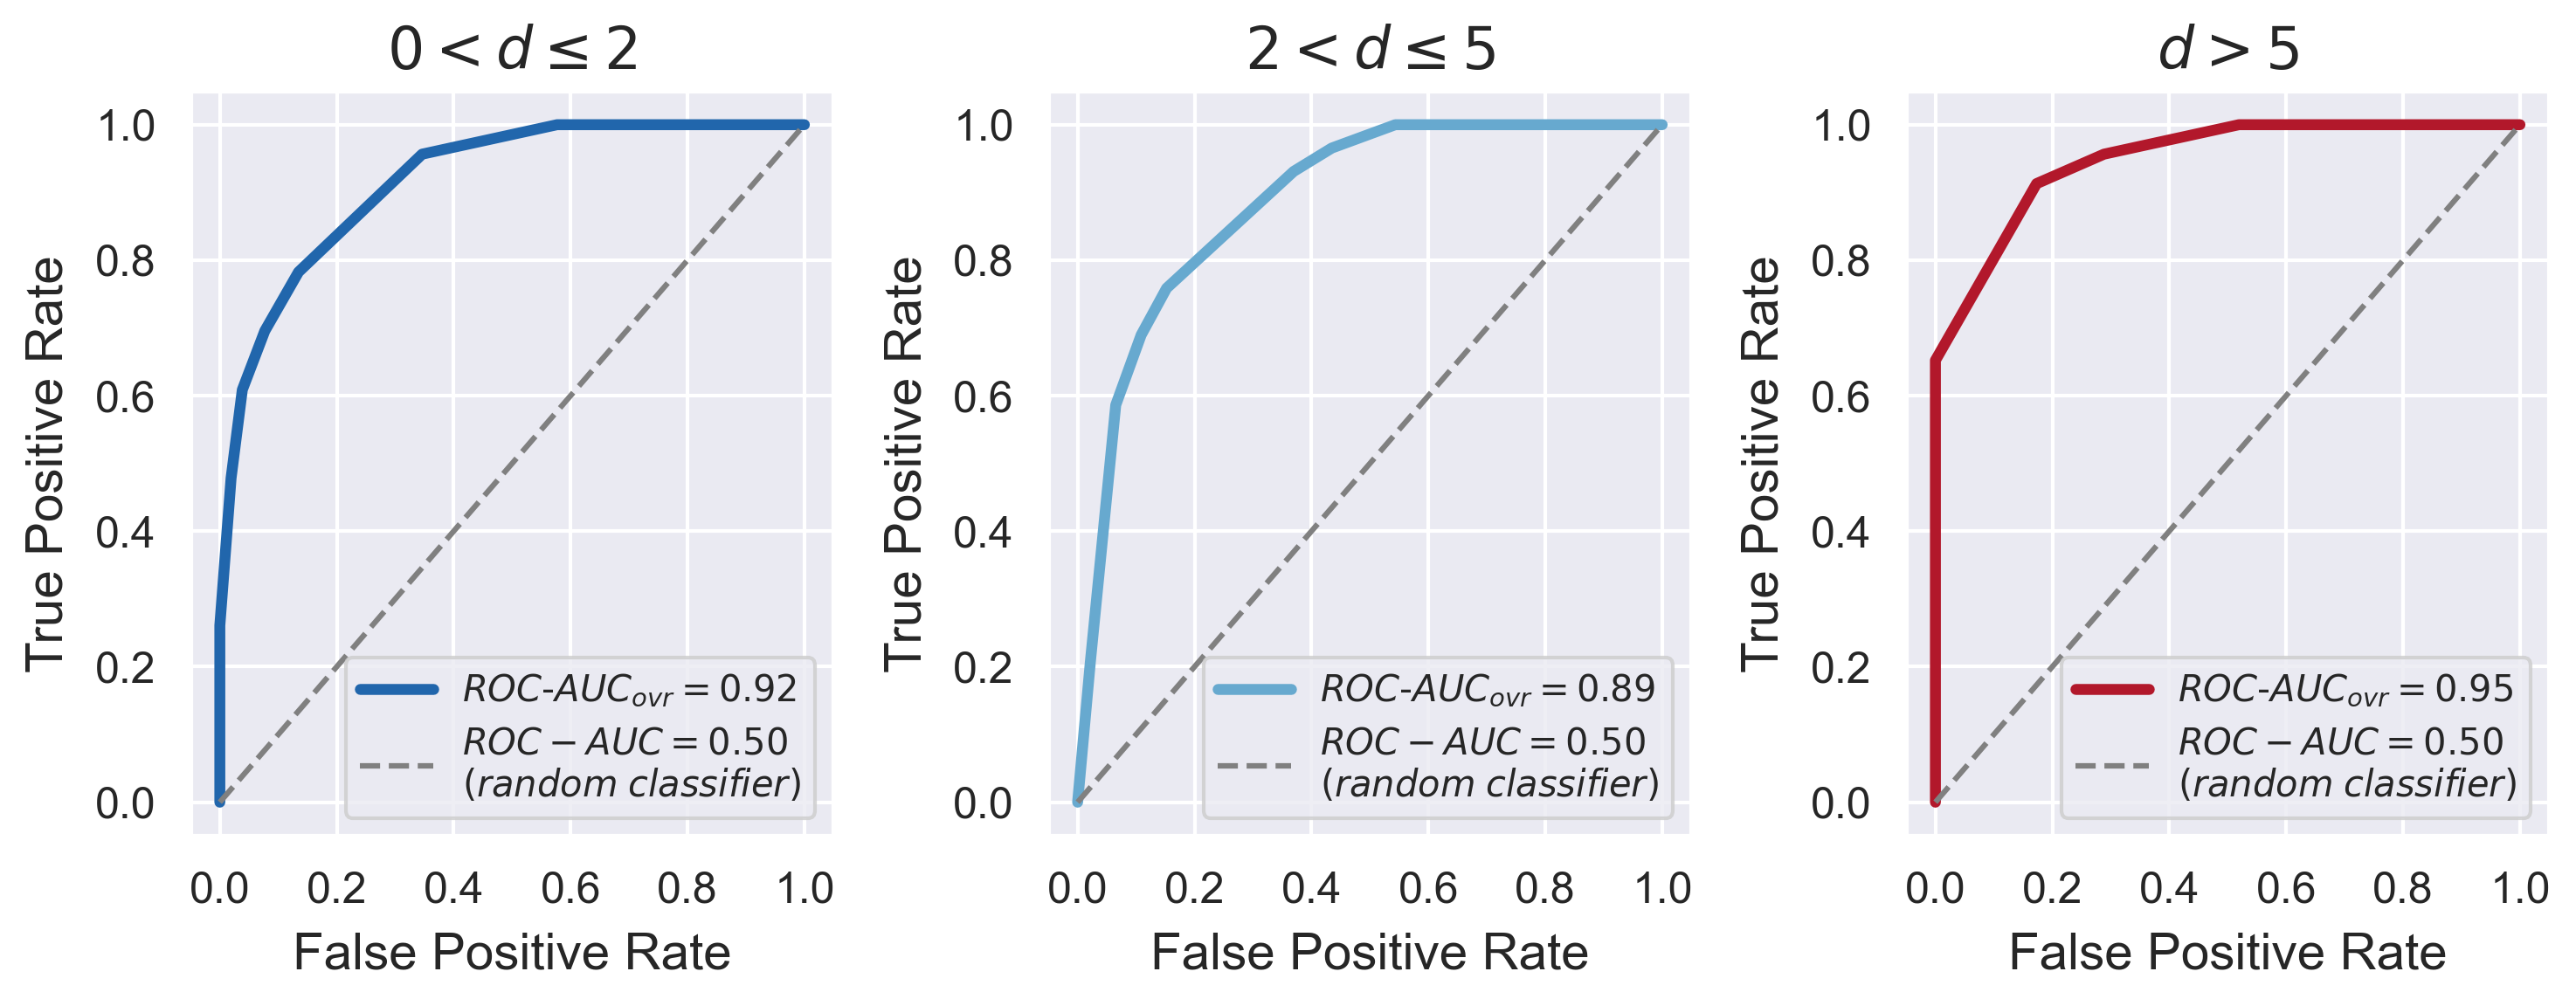

In [71]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X=X_selected,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [72]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

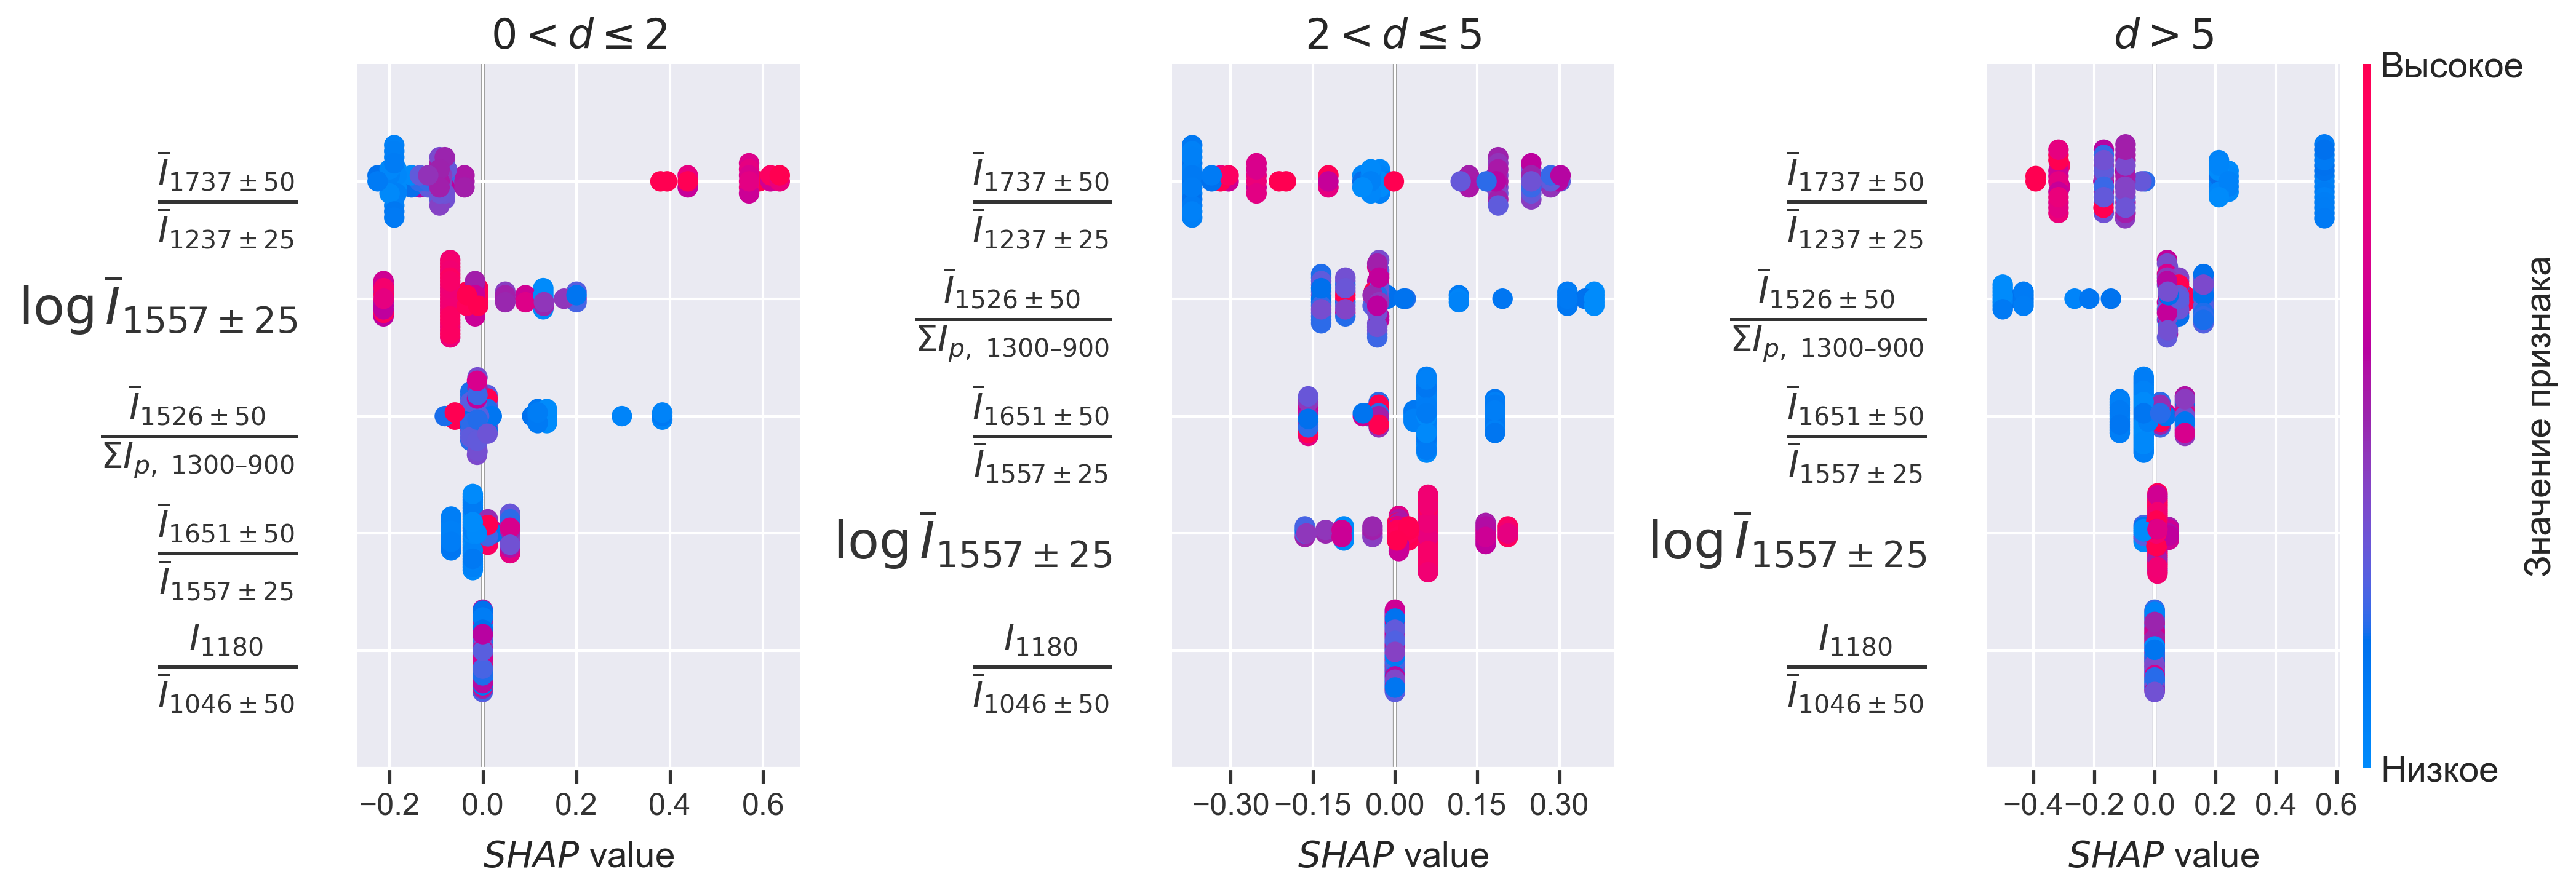

In [73]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    show_colorbar = (i == 2)
    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title

    plot_shap_summary_tree(
        model=model,
        X=X_selected,
        features_lst=selected_feats_3800_2200_1900_800,
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    ) 

plt.tight_layout()
# plt.savefig(f'{path_to_save}/shap_3_subplots_{range}.png', dpi=600)
plt.show()


### `3800-2200 x 1900-800` cm$^{-1}$

In [74]:
range = '3800_2200_1900_800'

#### Model optimization

In [75]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

In [76]:
model, X_selected, metrics_df, best_params = tree_analysis_gridsearch(
    df=features_df,
    feature_list=selected_feats_3800_2200_1900_800,
    target=target,
    param_grid=param_grid,
    cv_folds=5,
    scoring_metric='roc_auc_ovr',
    n_jobs=-1,
    random_state=42
)

Calculation progress:   0%|          | 0/5 [00:00<?, ?it/s]

*Model metrics*

In [77]:
display(metrics_df)

,$ROC-AUC_{ovr}$,$PR-AUC_{macro}$
Mean,0.815848,0.692664
"$CI_{95, cv}$",0.130232,0.168711
$all$ $sample$,0.966781,0.919111


*Model hyperparameters*

In [78]:
display(best_params)

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2}

#### *ROC*-curves visualization

In [79]:
PLOT_STYLE = {
    'FIGSIZE': (10, 4),
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': 'False Positive Rate',
    'Y_LABEL': 'True Positive Rate',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 12,
    'X_LABELPAD': 6,
    'Y_LABELPAD': 6,
    'LEGEND_FONT_SIZE': 10,
    'X_NBINS': 6,
    'Y_NBINS': 6,
    'LINE_WIDTH': 3.0
}

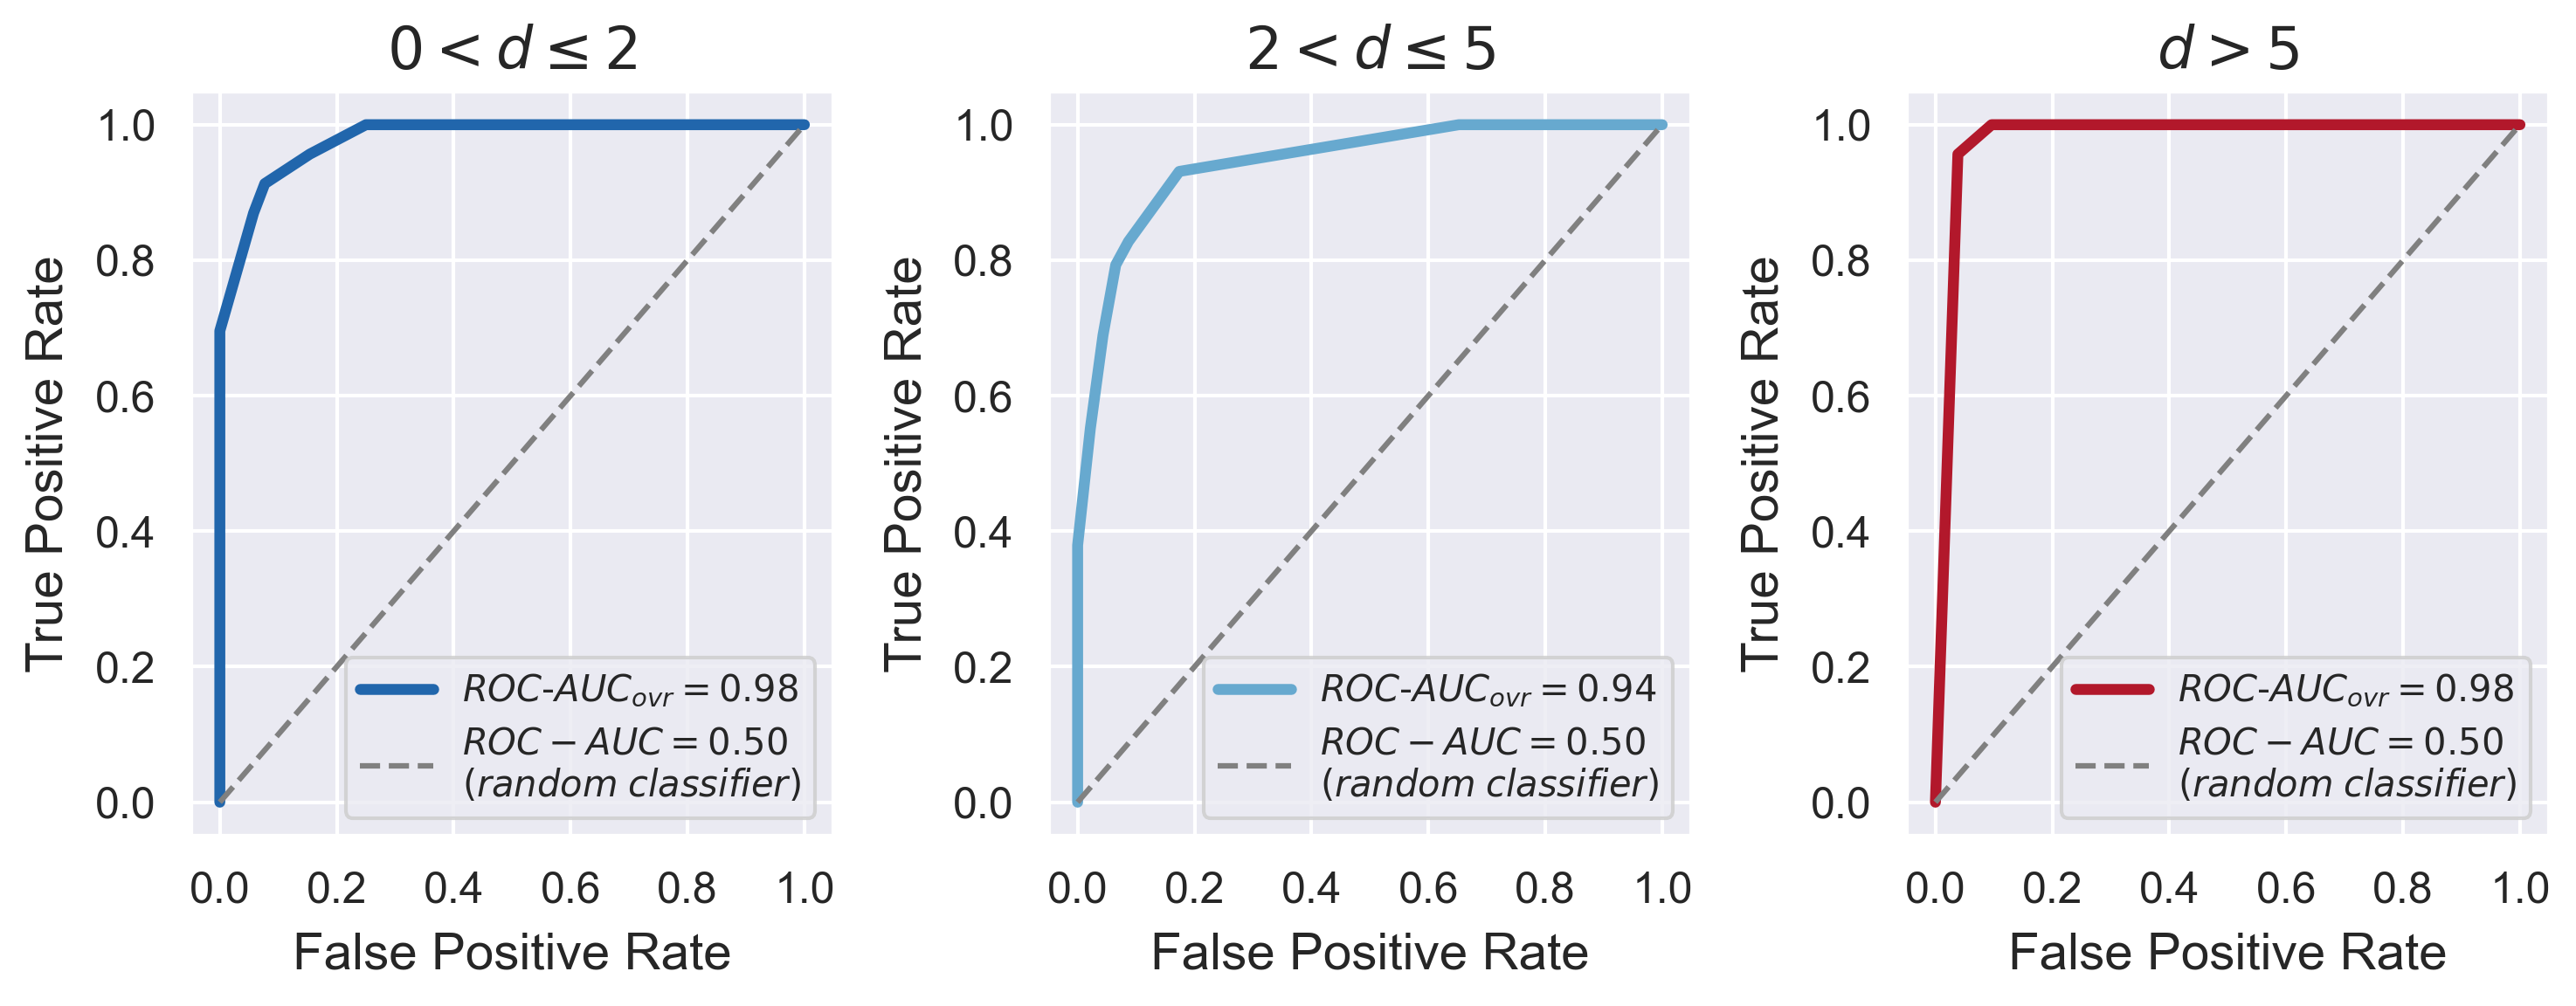

In [80]:
fig, axes = plt.subplots(1, 3, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    plot_roc_curve_per_class(
        model=model,
        X=X_selected,
        y_true=target,
        class_index=i,
        ax=ax
    )

plt.tight_layout()

plt.savefig(f'{path_to_save}/roc_curves_{range}.png', dpi=600)

plt.show()

#### *SHAP-values* diagram

In [81]:
PLOT_STYLE = {
    'FIGSIZE': (14, 5),
    'TITLE': '',
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL': '$SHAP$ value',
    'Y_LABEL': '',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 12,
    'Y_TICK_LABEL_FONT_SIZE': 20,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 20,
    'DOT_SIZE': 64,
    'LEGEND_TITLE': 'Значение признака',
    'LEGEND_FONT_SIZE': 14,
    'X_NBINS': 6,
    'COLORBAR_TICKS': ['Низкое', 'Высокое']
}

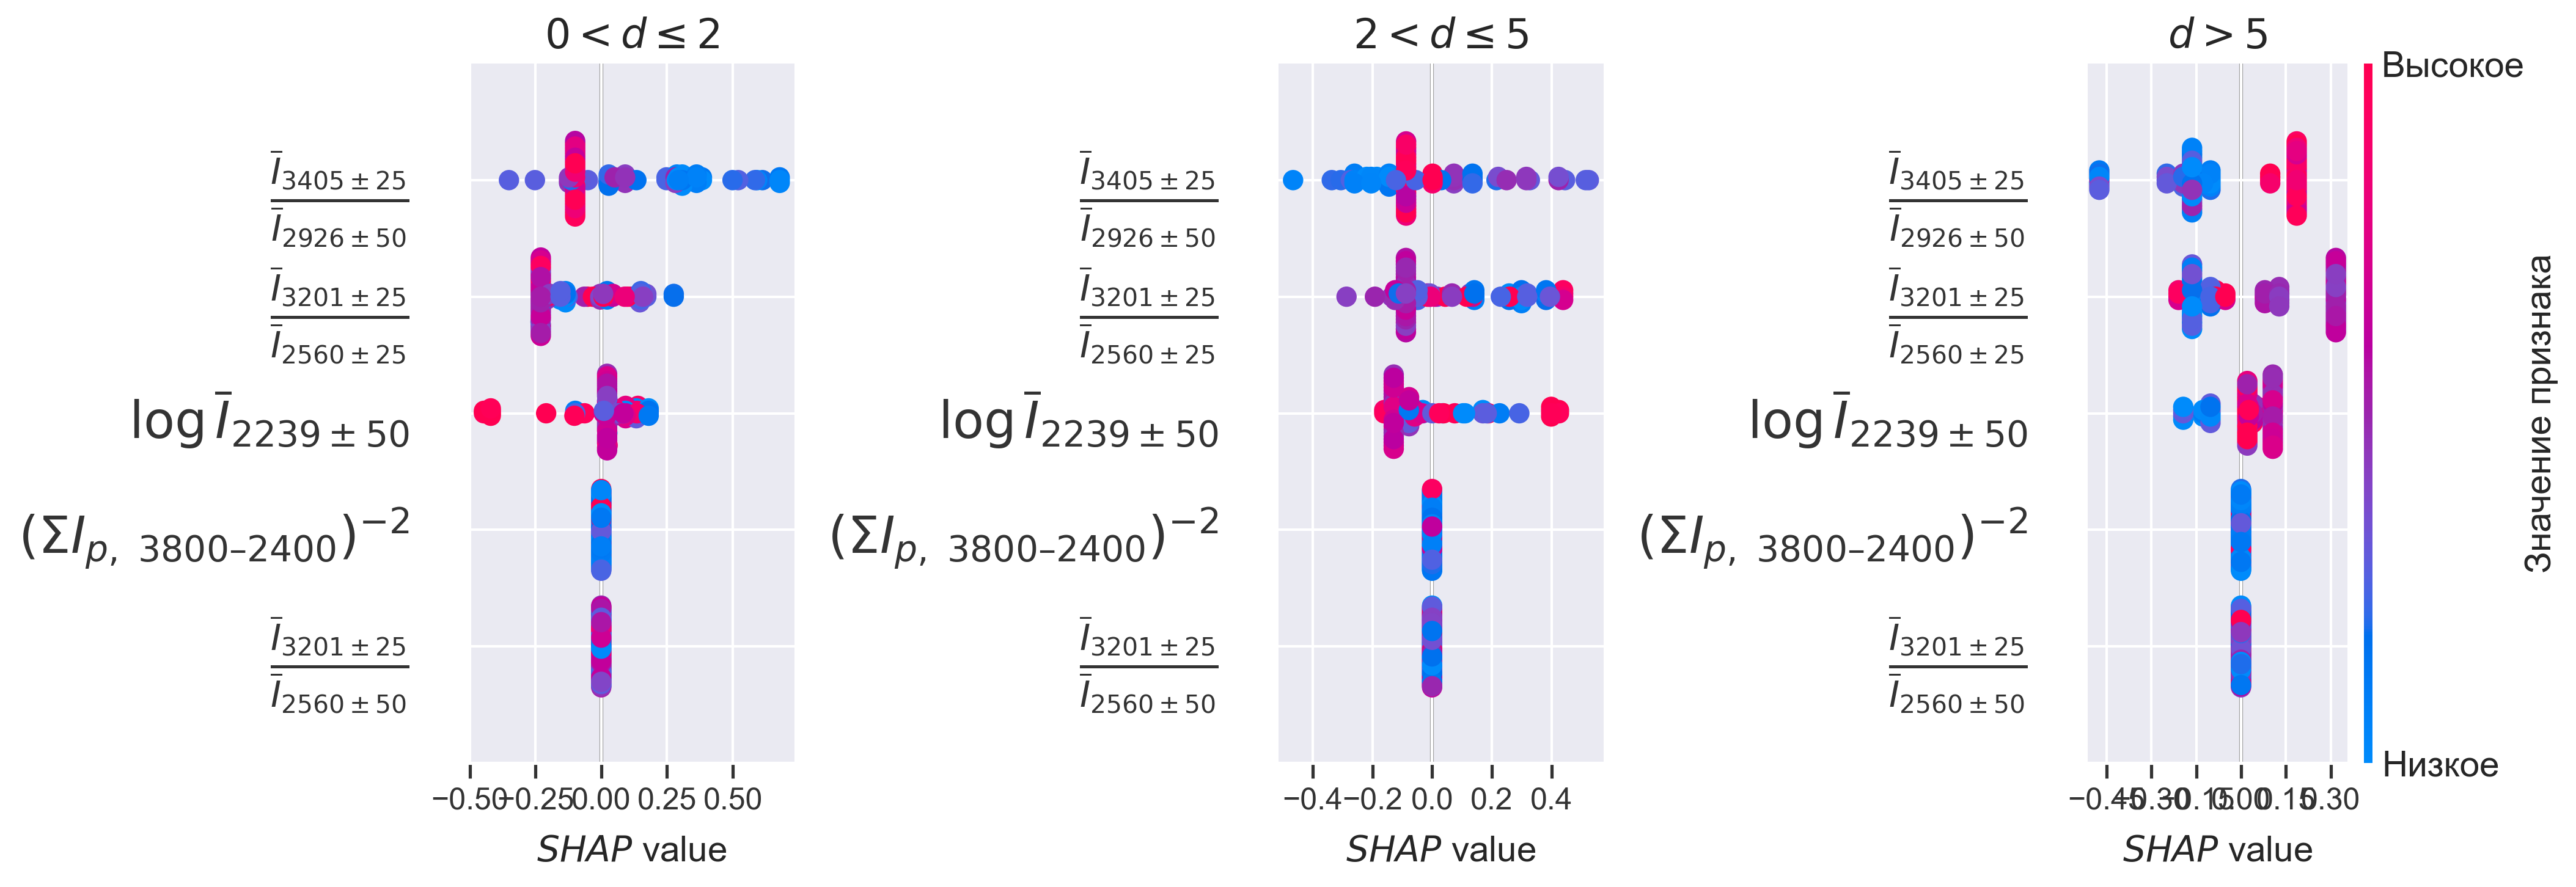

In [82]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize=PLOT_STYLE['FIGSIZE'], dpi=300)
axes = axes.flat

for i, ax in enumerate(axes):
    show_colorbar = (i == 2)
    fraction_group_title = class_fraction_group_dict[i]
    PLOT_STYLE['TITLE'] = fraction_group_title

    plot_shap_summary_tree(
        model=model,
        X=X_selected,  # только те признаки, на которых обучалась модель
        features_lst=selected_feats_3800_2200_1900_800,
        class_index=i,
        max_display=20,
        show_colorbar=show_colorbar,
        ax=ax
    )

plt.tight_layout()
# plt.savefig(f'{path_to_save}/shap_3_subplots_{range}.png', dpi=600)
plt.show()
